<a href="https://colab.research.google.com/github/tanatiem/BADS7105-CRM-Analytics/blob/main/Homework%2008%20-%20Campaign%20Response%20Model/hw08-compaign-response-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 8 - Campaign Response Model
**Subject:** BADS 7105 - CRM Analytics and Intelligence  
**Student:** Tanat Iempreedee (6210422036)

# Initalization

In [1]:
!pip install --upgrade scikit-learn

     |████████████████████████████████| 22.3MB 59.7MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, auc
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import plot_importance
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import six
import sys
sys.modules['sklearn.externals.six'] = six

import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

from sklearn.utils import _safe_indexing
sys.modules['sklearn.utils.safe_indexing'] = _safe_indexing

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.pipeline import make_pipeline

random_state = 18

In [3]:
%cd "/content/drive/My Drive/BADS/7105 CRM/work/08 - Campaign Response Model"

/content/drive/My Drive/BADS/7105 CRM/work/08 - Campaign Response Model


# Load Dataset

In [5]:
df_response = pd.read_csv('Retail_Data_Response.csv')
print(df_response.shape)

df_transactions = pd.read_csv('Retail_Data_Transactions.csv', parse_dates=['trans_date'])
print(df_transactions.shape)

(6884, 2)
(125000, 3)


In [ ]:
print(f'Shape: {df_response.shape}')
print(f'Unique: {df_response.customer_id.nunique()}')
df_response.head()

Shape: (6884, 2)
Unique: 6884


,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [ ]:
print(f'Shape: {df_transactions.shape}')
print(f'Unique: {df_transactions.customer_id.nunique()}')
df_transactions.head()

Shape: (125000, 3)
Unique: 6889


,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [ ]:
# There are 5 customers without response data, will be trimmed out
set(df_transactions.customer_id).difference(df_response.customer_id)

{'CS7297', 'CS7413', 'CS7638', 'CS8376', 'CS8753'}

# EDA

In [ ]:
df_transactions['tran_amount'].describe()

count    125000.000000
mean         64.991912
std          22.860006
min          10.000000
25%          47.000000
50%          65.000000
75%          83.000000
max         105.000000
Name: tran_amount, dtype: float64

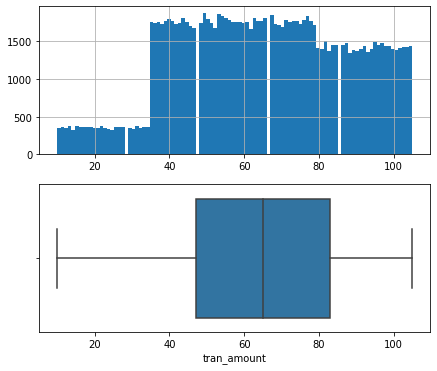

In [ ]:
fig, axes = plt.subplots(2,1, figsize=(7,6))
df_transactions['tran_amount'].hist(bins=100, ax=axes[0])
sns.boxplot(data=df_transactions, x='tran_amount', ax=axes[1]);

## Time series

In [ ]:
df_transactions['trans_date'].min(), df_transactions['trans_date'].max()

(Timestamp('2011-05-16 00:00:00'), Timestamp('2015-03-16 00:00:00'))

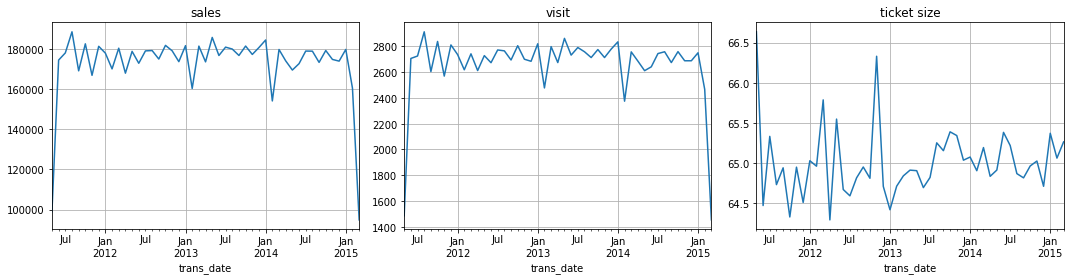

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(15,4), tight_layout=True)
axes = axes.ravel()

df_transactions.groupby(pd.Grouper(key='trans_date',freq='M'))['tran_amount'].sum().plot(title='sales', ax=axes[0])
df_transactions.groupby(pd.Grouper(key='trans_date',freq='M'))['tran_amount'].size().plot(title='visit', ax=axes[1])
df_transactions.groupby(pd.Grouper(key='trans_date',freq='M'))['tran_amount'].apply(lambda x: x.sum()/x.count()).plot(title='ticket size')
for ax in axes:
    ax.grid(True)

plt.show()

## Cohort Analysis

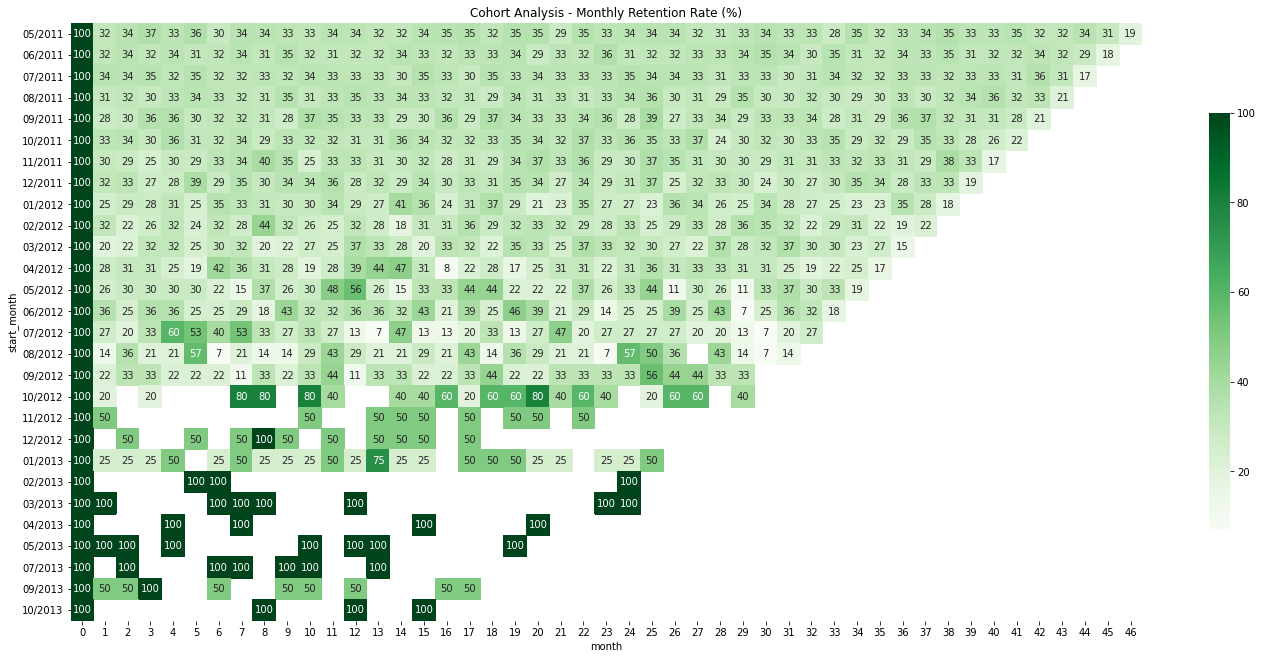

In [ ]:
cohort = df_transactions.groupby(['customer_id', pd.Grouper(key='trans_date',freq='M')]).size().reset_index()
cohort['start_month'] = cohort['customer_id'].map(cohort.groupby('customer_id')['trans_date'].min())
cohort['month'] = cohort.apply(lambda x: (x['trans_date'].year - x['start_month'].year)*12 + (x['trans_date'].month - x['start_month'].month) , axis=1)
cohort = pd.pivot_table(cohort, index='start_month', columns='month', values='customer_id', aggfunc='count').sort_index()
cohort = cohort.divide(cohort.iloc[:,0], axis=0).multiply(100)
cohort.index = cohort.index.strftime('%m/%Y')
plt.figure(figsize=(24,11))
sns.heatmap(cohort, cmap='Greens', annot=True, fmt='.0f', cbar_kws={'shrink':.7})
# plt.yticks(cohort.index.strftime('%m/%Y'))
plt.title('Cohort Analysis - Monthly Retention Rate (%)');

# Data Prep

In [ ]:
campaign_date = dt.datetime(2015,3,17)

df_transactions['age'] = (campaign_date - df_transactions['trans_date']).dt.days
df_transactions['is_weekend'] = df_transactions['trans_date'].dt.weekday.isin([5,6])

basket_cuts = [0,35,80,float('inf')]
df_transactions['basket_size'] = pd.cut(df_transactions['tran_amount'], basket_cuts, right=False, labels=['S','M','L'])

df_transactions = df_transactions.sort_values(['customer_id','trans_date'])
df_transactions.head(10)

,customer_id,trans_date,tran_amount,age,is_weekend,basket_size
77247,CS1112,2011-06-15,56,1371,False,M
89149,CS1112,2011-08-19,96,1306,False,L
68206,CS1112,2011-10-02,60,1262,True,M
36486,CS1112,2012-04-08,56,1073,True,M
93074,CS1112,2012-06-24,52,996,True,M
67735,CS1112,2012-07-03,81,987,False,L
89734,CS1112,2012-09-16,72,912,True,M
40368,CS1112,2012-12-15,76,822,True,M
87839,CS1112,2013-03-01,105,746,False,L
42084,CS1112,2013-07-01,36,624,False,M


## Feature Engineering

In [ ]:
df = df_transactions.groupby('customer_id').agg(
        recency=('age', min),                       
        frequency=('customer_id', len),                  
        monetary=('tran_amount', sum), 
        tenure=('age', max),
        length_of_stay=('age', lambda x: x.max() - x.min()),
     )

# weekend stats
weekend_df = df_transactions.groupby(['customer_id','is_weekend'])['tran_amount'].agg(['size','sum','mean']).unstack(fill_value=0)
weekend_df.columns = ['visit_weekday','visit_weekend','spend_weekday','spend_weekend','ticket_size_weekday','ticket_size_weekend']
df = df.join(weekend_df)

# basket size stats
basket_size_df = df_transactions.groupby(['customer_id','basket_size'])['tran_amount'].agg(['size','sum']).unstack()
basket_size_df.columns = ['visit_basket_s','visit_basket_m','visit_basket_l','spend_basket_s','spend_basket_m','spend_basket_l']
df = df.join(basket_size_df)

df = df.join(df_transactions.groupby('customer_id').agg(
    ticket_size=('tran_amount','mean'),
    std_ticket_size=('tran_amount','std'),
    med_ticket_size=('tran_amount','median'),
    mad_ticket_size=('tran_amount','mad'),
    
))

# Time to Event
event_df = df_transactions.groupby(['customer_id','trans_date']).size().reset_index(name='num_trans')
event_df['prev_date'] = event_df.groupby('customer_id')['trans_date'].shift(1)
event_df['num_repeat_sameday'] = event_df['num_trans'] - 1
event_df['duration'] = (event_df['trans_date'] - event_df['prev_date']).dt.days

df = df.join(event_df.groupby('customer_id').agg(avg_duration=('duration','mean'),std_duration=('duration','std'),
                                                # med_duration=('duration','median'), mad_duration=('duration','mad'),
                                                num_repeat_periods=('trans_date', lambda x: x.count() - 1),
                                                num_repeat_sameday=('num_repeat_sameday','sum')))

# df['recency_score'] = (df['recency'] - df['avg_duration'])/df['std_duration']
# df['recency_score'] = np.log(df['recency'] / df['avg_duration'])

# RFM & Time to event for each past X months
periods = [6, 12, 18, 24]
for n in periods:
    window_df = df_transactions[df_transactions.trans_date > df_transactions.trans_date.max() - relativedelta(months=n)]

    df = df.join(window_df.groupby('customer_id')['tran_amount'].agg(
        [ (f'monetary_{n}m','sum'), (f'frequency_{n}m', 'size'), 
        (f'avg_spend_{n}m', 'mean'), (f'std_spend_{n}m', 'std'),
         (f'iqr_spend_{n}m', lambda x: x.quantile(0.75) - x.quantile(0.25))]
    ))

    event_df = window_df.groupby(['customer_id','trans_date']).size().reset_index(name='num_trans')
    event_df['prev_date'] = event_df.groupby('customer_id')['trans_date'].shift(1)
    event_df['duration'] = (event_df['trans_date'] - event_df['prev_date']).dt.days
    df = df.join(event_df.groupby('customer_id')['duration'].agg(
        [ (f'avg_dur_{n}m', 'mean'), (f'std_dur_{n}m', 'std'), 
         (f'iqr_dur_{n}m', lambda x: x.quantile(.75) - x.quantile(.25)),
         (f'num_repeat_{n}m', 'count')
         ]
    ))

df['velocity_monetary_6_12'] = df['avg_spend_6m'] / (df['monetary_12m']/12)
df['velocity_monetary_6_18'] = df['avg_spend_6m'] / (df['monetary_18m']/18)
df['velocity_monetary_6_24'] = df['avg_spend_6m'] / (df['monetary_24m']/24)
df['velocity_monetary_12_18'] = df['avg_spend_12m'] / (df['monetary_18m']/18)
df['velocity_monetary_12_24'] = df['avg_spend_12m'] / (df['monetary_24m']/24)


df.fillna(0, inplace=True)
df = df_response.set_index('customer_id').join(df)
df.head()

,response,recency,frequency,monetary,tenure,length_of_stay,visit_weekday,visit_weekend,spend_weekday,spend_weekend,ticket_size_weekday,ticket_size_weekend,visit_basket_s,visit_basket_m,visit_basket_l,spend_basket_s,spend_basket_m,spend_basket_l,ticket_size,std_ticket_size,med_ticket_size,mad_ticket_size,avg_duration,std_duration,num_repeat_periods,num_repeat_sameday,monetary_6m,frequency_6m,avg_spend_6m,std_spend_6m,iqr_spend_6m,avg_dur_6m,std_dur_6m,iqr_dur_6m,num_repeat_6m,monetary_12m,frequency_12m,avg_spend_12m,std_spend_12m,iqr_spend_12m,avg_dur_12m,std_dur_12m,iqr_dur_12m,num_repeat_12m,monetary_18m,frequency_18m,avg_spend_18m,std_spend_18m,iqr_spend_18m,avg_dur_18m,std_dur_18m,iqr_dur_18m,num_repeat_18m,monetary_24m,frequency_24m,avg_spend_24m,std_spend_24m,iqr_spend_24m,avg_dur_24m,std_dur_24m,iqr_dur_24m,num_repeat_24m,velocity_monetary_6_12,velocity_monetary_6_18,velocity_monetary_6_24,velocity_monetary_12_18,velocity_monetary_12_24
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CS1112,0,62,15,1012,1371,1309,10,5,696,316,69.600000,63.200000,0,11,4,0.0,640.0,372.0,67.466667,19.766012,63.0,15.831111,93.500000,50.873523,14,0,98.0,2.0,49.000000,14.142136,10.0,41.0,0.000000,0.0,1.0,251.0,4.0,62.750000,20.982135,15.75,86.666667,50.560195,50.00,3.0,322.0,5.0,64.400000,18.541845,12.00,106.750000,57.598466,78.75,4.0,358.0,6.0,59.666667,20.235283,25.0,112.400000,51.456778,63.00,5.0,2.342629,2.739130,3.284916,3.507764,4.206704
CS1113,0,36,20,1490,1390,1354,17,3,1296,194,76.235294,64.666667,0,10,10,0.0,566.0,924.0,74.500000,21.254102,79.5,18.300000,75.222222,53.395919,18,1,220.0,3.0,73.333333,27.300794,27.0,26.0,0.000000,0.0,1.0,393.0,6.0,65.500000,28.939592,51.25,74.000000,65.181797,54.50,4.0,446.0,7.0,63.714286,26.837252,45.50,79.600000,57.821276,64.00,5.0,775.0,11.0,70.454545,23.888757,43.0,73.333333,58.030165,76.00,9.0,2.239186,2.959641,2.270968,2.643498,2.028387
CS1114,1,33,19,1432,1342,1309,13,6,955,477,73.461538,79.500000,0,10,9,0.0,589.0,843.0,75.368421,21.341692,79.0,17.955679,72.722222,73.693168,18,0,211.0,3.0,70.333333,29.955523,29.0,31.0,16.970563,12.0,2.0,315.0,5.0,63.000000,23.822258,33.00,41.250000,44.002841,43.25,4.0,652.0,9.0,72.444444,26.495807,49.00,53.375000,69.903888,42.50,8.0,804.0,11.0,73.090909,24.010225,42.5,62.600000,64.740851,82.00,10.0,2.679365,1.941718,2.099502,1.739264,1.880597
CS1115,1,12,22,1659,1315,1303,16,6,1183,476,73.937500,79.333333,0,13,9,0.0,816.0,843.0,75.409091,18.151896,72.5,15.264463,62.047619,55.413425,21,0,55.0,1.0,55.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,248.0,3.0,82.666667,24.006943,21.50,165.000000,134.350288,95.00,2.0,590.0,8.0,73.750000,16.951612,16.75,76.142857,85.762130,54.00,7.0,831.0,11.0,75.545455,15.577956,19.5,71.500000,71.019950,47.75,10.0,2.661290,1.677966,1.588448,2.522034,2.387485
CS1116,1,204,13,857,1359,1155,12,1,797,60,66.416667,60.000000,0,8,5,0.0,399.0,458.0,65.923077,22.940000,60.0,19.751479,96.250000,107.361010,12,0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,286.0,4.0,71.500000,26.248809,36.50,52.333333,37.740341,34.50,3.0,333.0,5.0,66.600000,25.234896,43.00,49.750000,31.245000,38.25,4.0,333.0,5.0,66.600000,25.234896,43.0,49.750000,31.245000,38.25,4.0,0.000000,0.000000,0.000000,3.864865,5.153153


## Big spender

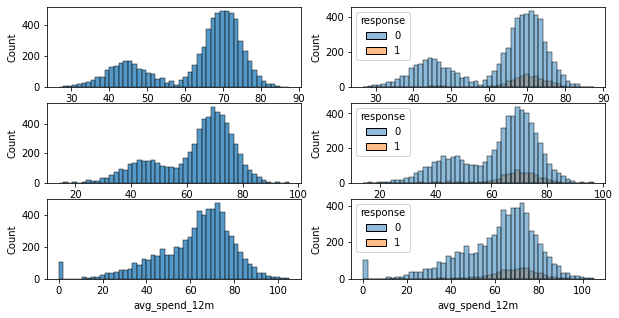

In [ ]:
fig, axes = plt.subplots(3,2, figsize=(10,5))
axes = axes.ravel()
sns.histplot(data=df, x='ticket_size',bins=50, ax=axes[0])
sns.histplot(data=df, x='ticket_size',bins=50, hue='response', ax=axes[1])
sns.histplot(data=df, x='avg_spend_24m',bins=50, ax=axes[2])
sns.histplot(data=df, x='avg_spend_24m',bins=50, hue='response', ax=axes[3])
sns.histplot(data=df, x='avg_spend_12m',bins=50, ax=axes[4])
sns.histplot(data=df, x='avg_spend_12m',bins=50, hue='response', ax=axes[5])
plt.show();

In [ ]:
from sklearn.mixture import GaussianMixture

random_state = 18
# data = df[['ticket_size']].copy() # not using LTD, maybe
# data = df[['avg_spend_24m']].copy()
data = df[['avg_spend_12m']].copy()
gm = GaussianMixture(n_components=2, random_state=random_state).fit(data)
labels = gm.predict(data)
prob = gm.predict_proba(data)
data['is_big_spender'] = (labels == 0).astype('int')
data['prob_big_spender'] = np.round(prob[:,0],6)
data['response'] = df['response']
print(gm.means_)

[[69.96189895]
 [43.70914768]]


In [ ]:
# temp = data.groupby('is_big_spender').agg(count=('ticket_size','size'), response=('response','sum'))
# temp = data.groupby('is_big_spender').agg(count=('avg_spend_24m','size'), response=('response','sum'))
temp = data.groupby('is_big_spender').agg(count=('avg_spend_12m','size'), response=('response','sum'))
temp['% response'] = temp['response'] / temp['count']
temp

,count,response,% response
is_big_spender,,,
0,1650,49,0.029697
1,5234,598,0.114253


In [ ]:
df = df.join(data[['is_big_spender','prob_big_spender']])
df.head()

,response,recency,frequency,monetary,tenure,length_of_stay,visit_weekday,visit_weekend,spend_weekday,spend_weekend,ticket_size_weekday,ticket_size_weekend,visit_basket_s,visit_basket_m,visit_basket_l,spend_basket_s,spend_basket_m,spend_basket_l,ticket_size,std_ticket_size,med_ticket_size,mad_ticket_size,avg_duration,std_duration,num_repeat_periods,num_repeat_sameday,monetary_6m,frequency_6m,avg_spend_6m,std_spend_6m,iqr_spend_6m,avg_dur_6m,std_dur_6m,iqr_dur_6m,num_repeat_6m,monetary_12m,frequency_12m,avg_spend_12m,std_spend_12m,iqr_spend_12m,avg_dur_12m,std_dur_12m,iqr_dur_12m,num_repeat_12m,monetary_18m,frequency_18m,avg_spend_18m,std_spend_18m,iqr_spend_18m,avg_dur_18m,std_dur_18m,iqr_dur_18m,num_repeat_18m,monetary_24m,frequency_24m,avg_spend_24m,std_spend_24m,iqr_spend_24m,avg_dur_24m,std_dur_24m,iqr_dur_24m,num_repeat_24m,velocity_monetary_6_12,velocity_monetary_6_18,velocity_monetary_6_24,velocity_monetary_12_18,velocity_monetary_12_24,is_big_spender,prob_big_spender
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CS1112,0,62,15,1012,1371,1309,10,5,696,316,69.600000,63.200000,0,11,4,0.0,640.0,372.0,67.466667,19.766012,63.0,15.831111,93.500000,50.873523,14,0,98.0,2.0,49.000000,14.142136,10.0,41.0,0.000000,0.0,1.0,251.0,4.0,62.750000,20.982135,15.75,86.666667,50.560195,50.00,3.0,322.0,5.0,64.400000,18.541845,12.00,106.750000,57.598466,78.75,4.0,358.0,6.0,59.666667,20.235283,25.0,112.400000,51.456778,63.00,5.0,2.342629,2.739130,3.284916,3.507764,4.206704,1,0.852763
CS1113,0,36,20,1490,1390,1354,17,3,1296,194,76.235294,64.666667,0,10,10,0.0,566.0,924.0,74.500000,21.254102,79.5,18.300000,75.222222,53.395919,18,1,220.0,3.0,73.333333,27.300794,27.0,26.0,0.000000,0.0,1.0,393.0,6.0,65.500000,28.939592,51.25,74.000000,65.181797,54.50,4.0,446.0,7.0,63.714286,26.837252,45.50,79.600000,57.821276,64.00,5.0,775.0,11.0,70.454545,23.888757,43.0,73.333333,58.030165,76.00,9.0,2.239186,2.959641,2.270968,2.643498,2.028387,1,0.890187
CS1114,1,33,19,1432,1342,1309,13,6,955,477,73.461538,79.500000,0,10,9,0.0,589.0,843.0,75.368421,21.341692,79.0,17.955679,72.722222,73.693168,18,0,211.0,3.0,70.333333,29.955523,29.0,31.0,16.970563,12.0,2.0,315.0,5.0,63.000000,23.822258,33.00,41.250000,44.002841,43.25,4.0,652.0,9.0,72.444444,26.495807,49.00,53.375000,69.903888,42.50,8.0,804.0,11.0,73.090909,24.010225,42.5,62.600000,64.740851,82.00,10.0,2.679365,1.941718,2.099502,1.739264,1.880597,1,0.856799
CS1115,1,12,22,1659,1315,1303,16,6,1183,476,73.937500,79.333333,0,13,9,0.0,816.0,843.0,75.409091,18.151896,72.5,15.264463,62.047619,55.413425,21,0,55.0,1.0,55.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,248.0,3.0,82.666667,24.006943,21.50,165.000000,134.350288,95.00,2.0,590.0,8.0,73.750000,16.951612,16.75,76.142857,85.762130,54.00,7.0,831.0,11.0,75.545455,15.577956,19.5,71.500000,71.019950,47.75,10.0,2.661290,1.677966,1.588448,2.522034,2.387485,1,0.957852
CS1116,1,204,13,857,1359,1155,12,1,797,60,66.416667,60.000000,0,8,5,0.0,399.0,458.0,65.923077,22.940000,60.0,19.751479,96.250000,107.361010,12,0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,286.0,4.0,71.500000,26.248809,36.50,52.333333,37.740341,34.50,3.0,333.0,5.0,66.600000,25.234896,43.00,49.750000,31.245000,38.25,4.0,333.0,5.0,66.600000,25.234896,43.0,49.750000,31.245000,38.25,4.0,0.000000,0.000000,0.000000,3.864865,5.153153,1,0.934761


## BTYD (Experiment)

just trying Buy-Til-You-Die.

In [ ]:
!pip install lifetimes

     |████████████████████████████████| 593kB 5.0MB/s 


In [ ]:
# prep BTYD data by the definition of it
data = df[['num_repeat_periods','length_of_stay','tenure','ticket_size']].rename({'num_repeat_periods':'frequency', 'length_of_stay':'recency', 'tenure':'T', 'ticket_size':'monetary_value'}, axis=1).copy()
# data = df[['num_repeat_24m','length_of_stay','tenure','avg_spend_24m']].rename({'num_repeat_24m':'frequency', 'length_of_stay':'recency', 'tenure':'T', 'avg_spend_24m':'monetary_value'}, axis=1).copy()
# data['recency'] = data.apply(lambda x: x['recency'] if x['frequency'] > 0 else 0, axis=1)
data.head(5)

,frequency,recency,T,monetary_value
customer_id,,,,
CS1112,14,1309,1371,67.466667
CS1113,18,1354,1390,74.500000
CS1114,18,1309,1342,75.368421
CS1115,21,1303,1315,75.409091
CS1116,12,1155,1359,65.923077


In [ ]:
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter(penalizer_coef=.05)
bgf.fit(data['frequency'], data['recency'], data['T'])
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,2.018553e+00,2.479525e-02,1.969954e+00,2.067151e+00
alpha,1.568181e+02,2.383701e+00,1.521460e+02,1.614902e+02
a,2.602381e-19,1.296708e-13,-2.541544e-13,2.541550e-13
b,5.514482e-08,2.747572e-02,-5.385236e-02,5.385247e-02


### Predicted Number of Transactions in the future (1 year)

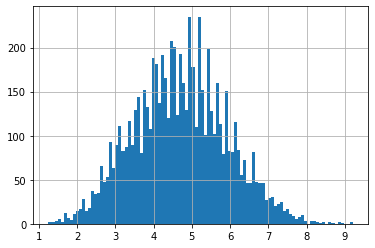

In [ ]:
df['expected_num_trans_1y'] = bgf.conditional_expected_number_of_purchases_up_to_time(365, data['frequency'], data['recency'], data['T'])
df['expected_num_trans_1y'].hist(bins=100);

### Predicted Customer Life Time Value (1 year)

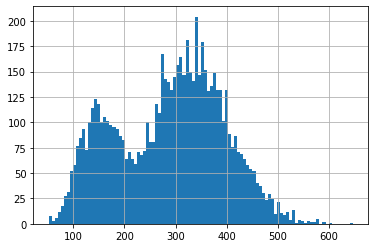

In [ ]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef=0.05)
ggf.fit(data['frequency'], data['monetary_value'])

df['clv_1y'] = ggf.customer_lifetime_value(bgf, data['frequency'], data['recency'], data['T'], data['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
)
df['clv_1y'].hist(bins=100);

## Save file

In [ ]:
df.to_csv('prep_customers.csv')

# Feature EDA

In [6]:
df = pd.read_csv('prep_customers.csv', index_col=0)
print(df.shape)
df.head()

(6884, 71)


,response,recency,frequency,monetary,tenure,length_of_stay,visit_weekday,visit_weekend,spend_weekday,spend_weekend,ticket_size_weekday,ticket_size_weekend,visit_basket_s,visit_basket_m,visit_basket_l,spend_basket_s,spend_basket_m,spend_basket_l,ticket_size,std_ticket_size,med_ticket_size,mad_ticket_size,avg_duration,std_duration,num_repeat_periods,num_repeat_sameday,monetary_6m,frequency_6m,avg_spend_6m,std_spend_6m,iqr_spend_6m,avg_dur_6m,std_dur_6m,iqr_dur_6m,num_repeat_6m,monetary_12m,frequency_12m,avg_spend_12m,std_spend_12m,iqr_spend_12m,avg_dur_12m,std_dur_12m,iqr_dur_12m,num_repeat_12m,monetary_18m,frequency_18m,avg_spend_18m,std_spend_18m,iqr_spend_18m,avg_dur_18m,std_dur_18m,iqr_dur_18m,num_repeat_18m,monetary_24m,frequency_24m,avg_spend_24m,std_spend_24m,iqr_spend_24m,avg_dur_24m,std_dur_24m,iqr_dur_24m,num_repeat_24m,velocity_monetary_6_12,velocity_monetary_6_18,velocity_monetary_6_24,velocity_monetary_12_18,velocity_monetary_12_24,is_big_spender,prob_big_spender,expected_num_trans_1y,clv_1y
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CS1112,0,62,15,1012,1371,1309,10,5,696,316,69.600000,63.200000,0,11,4,0.0,640.0,372.0,67.466667,19.766012,63.0,15.831111,93.500000,50.873523,14,0,98.0,2.0,49.000000,14.142136,10.0,41.0,0.000000,0.0,1.0,251.0,4.0,62.750000,20.982135,15.75,86.666667,50.560195,50.00,3.0,322.0,5.0,64.400000,18.541845,12.00,106.750000,57.598466,78.75,4.0,358.0,6.0,59.666667,20.235283,25.0,112.400000,51.456778,63.00,5.0,2.342629,2.739130,3.284916,3.507764,4.206704,1,0.852763,3.826877,246.084778
CS1113,0,36,20,1490,1390,1354,17,3,1296,194,76.235294,64.666667,0,10,10,0.0,566.0,924.0,74.500000,21.254102,79.5,18.300000,75.222222,53.395919,18,1,220.0,3.0,73.333333,27.300794,27.0,26.0,0.000000,0.0,1.0,393.0,6.0,65.500000,28.939592,51.25,74.000000,65.181797,54.50,4.0,446.0,7.0,63.714286,26.837252,45.50,79.600000,57.821276,64.00,5.0,775.0,11.0,70.454545,23.888757,43.0,73.333333,58.030165,76.00,9.0,2.239186,2.959641,2.270968,2.643498,2.028387,1,0.890187,4.723743,333.137567
CS1114,1,33,19,1432,1342,1309,13,6,955,477,73.461538,79.500000,0,10,9,0.0,589.0,843.0,75.368421,21.341692,79.0,17.955679,72.722222,73.693168,18,0,211.0,3.0,70.333333,29.955523,29.0,31.0,16.970563,12.0,2.0,315.0,5.0,63.000000,23.822258,33.00,41.250000,44.002841,43.25,4.0,652.0,9.0,72.444444,26.495807,49.00,53.375000,69.903888,42.50,8.0,804.0,11.0,73.090909,24.010225,42.5,62.600000,64.740851,82.00,10.0,2.679365,1.941718,2.099502,1.739264,1.880597,1,0.856799,4.875022,347.808945
CS1115,1,12,22,1659,1315,1303,16,6,1183,476,73.937500,79.333333,0,13,9,0.0,816.0,843.0,75.409091,18.151896,72.5,15.264463,62.047619,55.413425,21,0,55.0,1.0,55.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,248.0,3.0,82.666667,24.006943,21.50,165.000000,134.350288,95.00,2.0,590.0,8.0,73.750000,16.951612,16.75,76.142857,85.762130,54.00,7.0,831.0,11.0,75.545455,15.577956,19.5,71.500000,71.019950,47.75,10.0,2.661290,1.677966,1.588448,2.522034,2.387485,1,0.957852,5.708431,406.138371
CS1116,1,204,13,857,1359,1155,12,1,797,60,66.416667,60.000000,0,8,5,0.0,399.0,458.0,65.923077,22.940000,60.0,19.751479,96.250000,107.361010,12,0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,286.0,4.0,71.500000,26.248809,36.50,52.333333,37.740341,34.50,3.0,333.0,5.0,66.600000,25.234896,43.00,49.750000,31.245000,38.25,4.0,333.0,5.0,66.600000,25.234896,43.0,49.750000,31.245000,38.25,4.0,0.000000,0.000000,0.000000,3.864865,5.153153,1,0.934761,3.375584,213.184011


In [7]:
df.columns

Index(['response', 'recency', 'frequency', 'monetary', 'tenure',
       'length_of_stay', 'visit_weekday', 'visit_weekend', 'spend_weekday',
       'spend_weekend', 'ticket_size_weekday', 'ticket_size_weekend',
       'visit_basket_s', 'visit_basket_m', 'visit_basket_l', 'spend_basket_s',
       'spend_basket_m', 'spend_basket_l', 'ticket_size', 'std_ticket_size',
       'med_ticket_size', 'mad_ticket_size', 'avg_duration', 'std_duration',
       'num_repeat_periods', 'num_repeat_sameday', 'monetary_6m',
       'frequency_6m', 'avg_spend_6m', 'std_spend_6m', 'iqr_spend_6m',
       'avg_dur_6m', 'std_dur_6m', 'iqr_dur_6m', 'num_repeat_6m',
       'monetary_12m', 'frequency_12m', 'avg_spend_12m', 'std_spend_12m',
       'iqr_spend_12m', 'avg_dur_12m', 'std_dur_12m', 'iqr_dur_12m',
       'num_repeat_12m', 'monetary_18m', 'frequency_18m', 'avg_spend_18m',
       'std_spend_18m', 'iqr_spend_18m', 'avg_dur_18m', 'std_dur_18m',
       'iqr_dur_18m', 'num_repeat_18m', 'monetary_24m', 'frequen

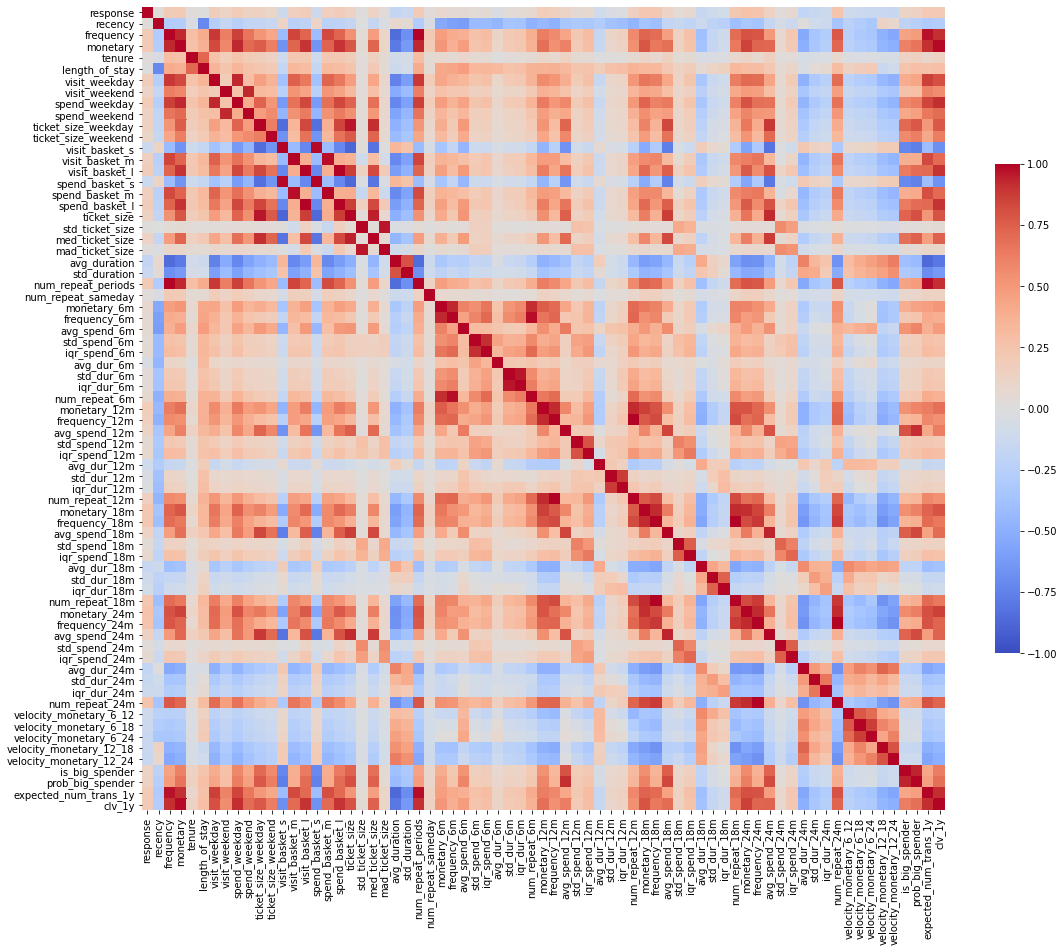

In [ ]:
plt.figure(figsize=(18,18))
sns.heatmap(df.corr(), cmap='coolwarm', vmin=-1, vmax=1, annot=False, fmt='.1f', square=True, cbar_kws = {'shrink':.5});

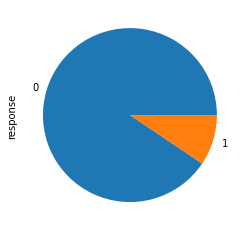

In [ ]:
df['response'].value_counts().plot.pie();

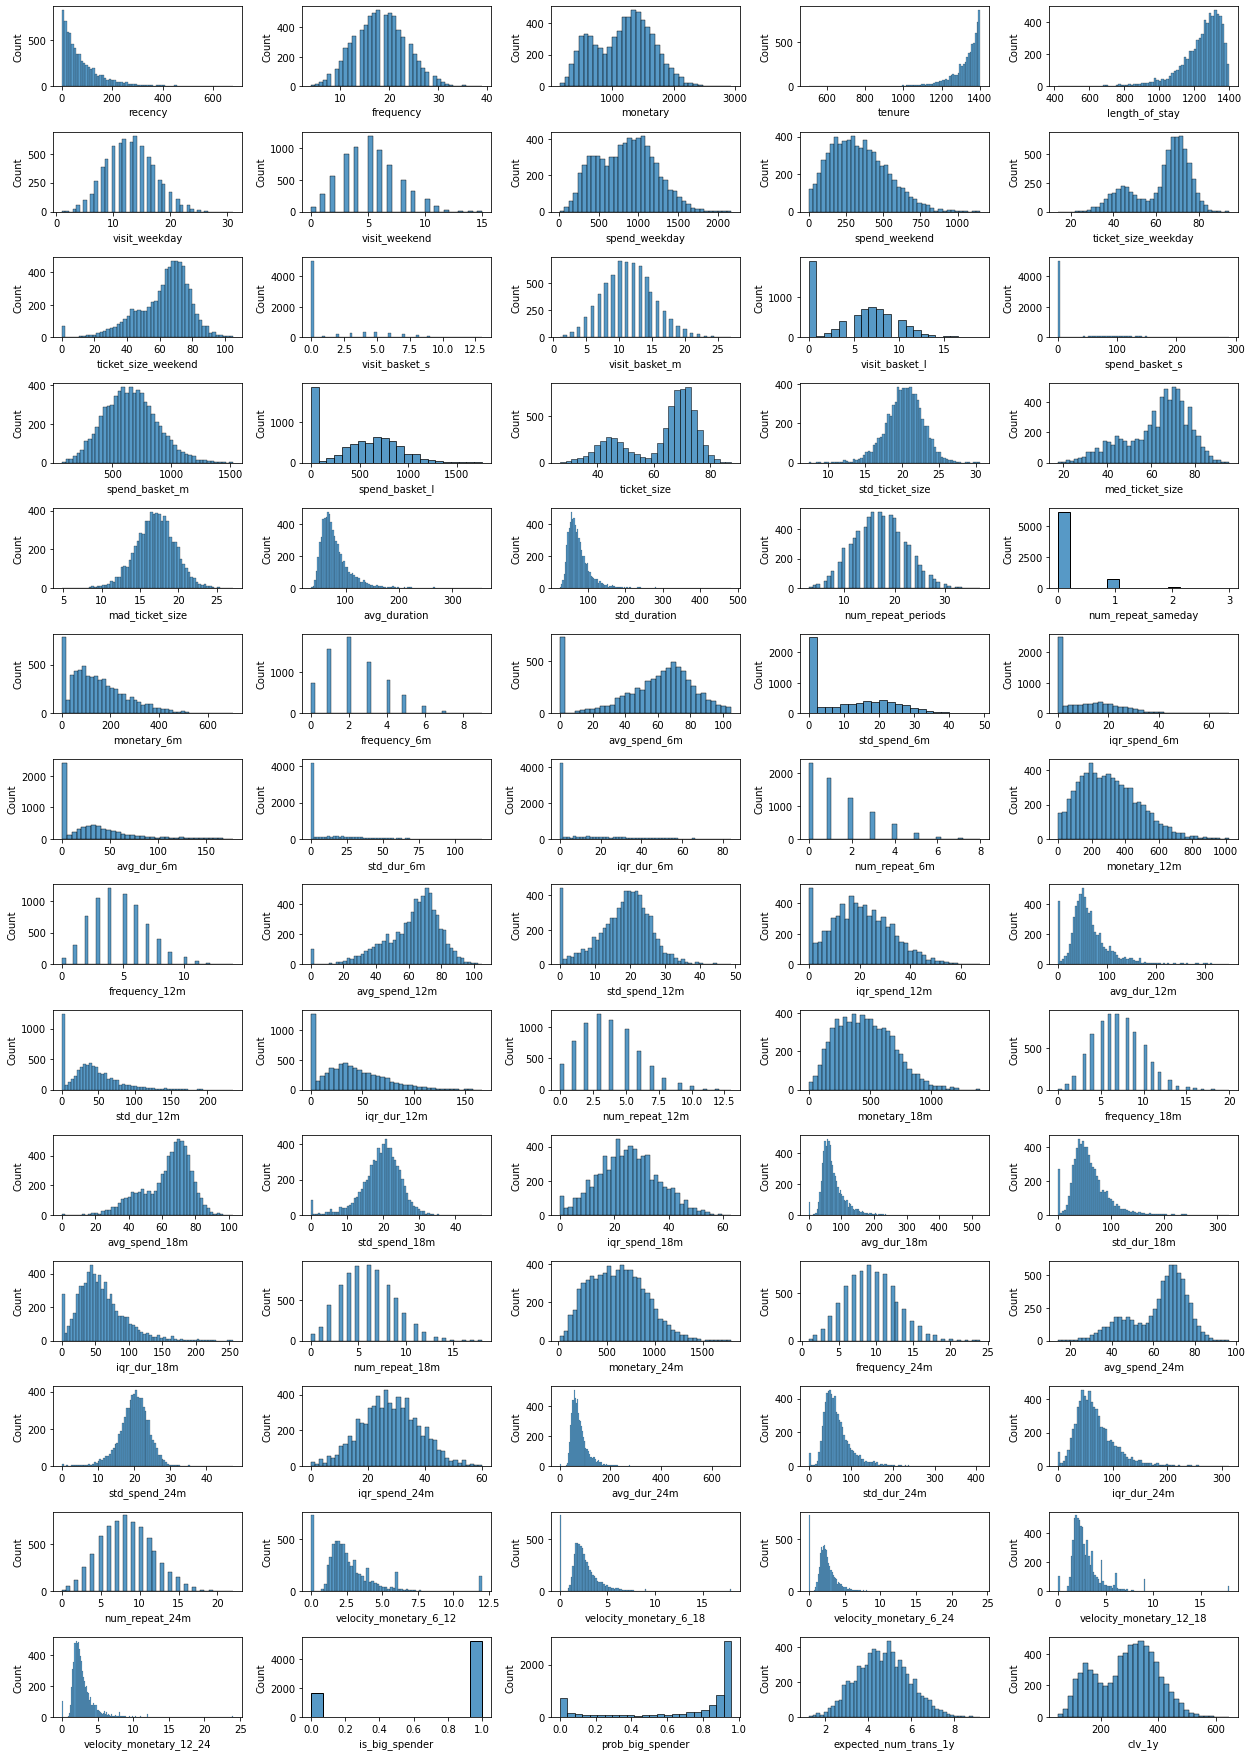

In [ ]:
n_cols = 5
n_rows, mod = divmod(len(df.columns[1:]), n_cols)
n_rows +=  int(mod > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3.5, n_rows*1.75), tight_layout=True)
axes = axes.ravel()
for col, ax in zip(df.columns[1:], axes):
    sns.histplot(df[col], ax=ax)
plt.show()

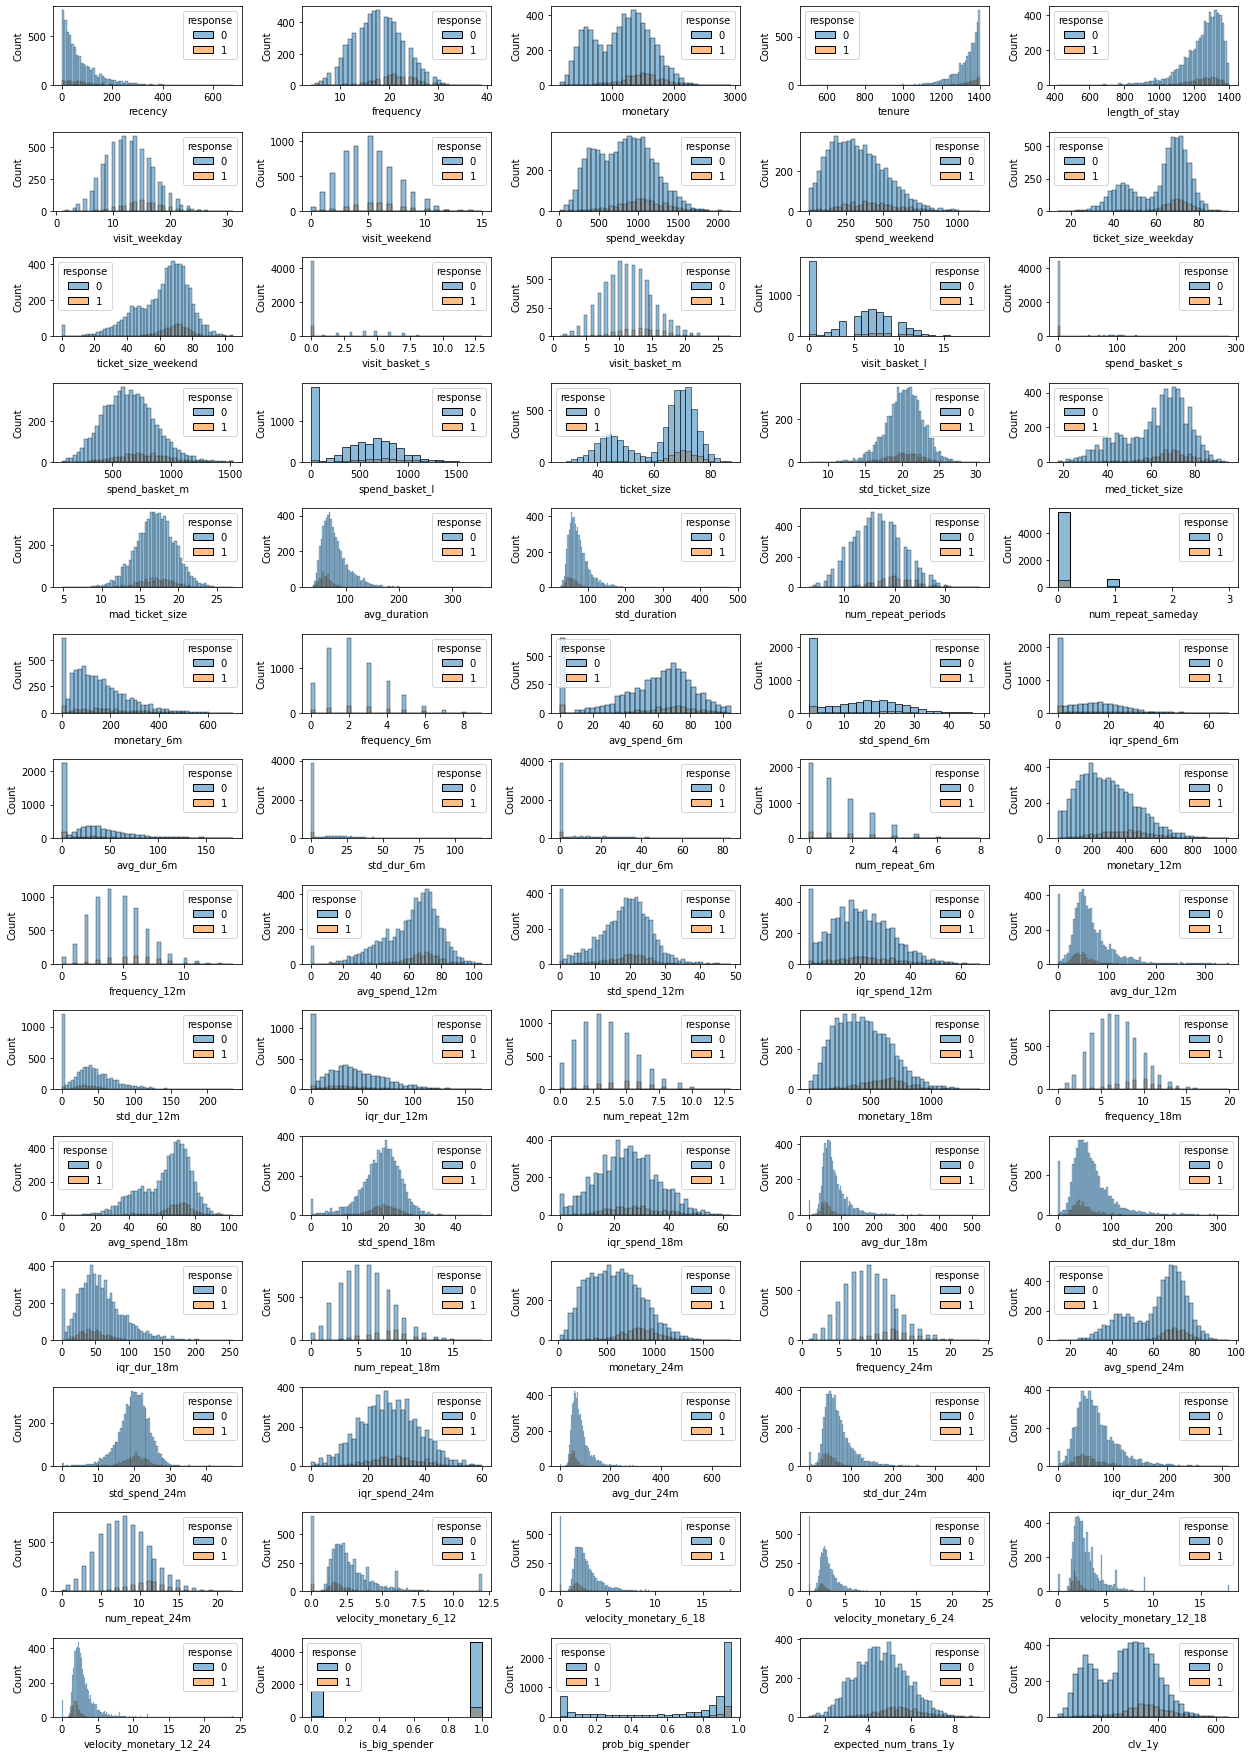

In [ ]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3.5, n_rows*1.75), tight_layout=True)
axes = axes.ravel()
for col, ax in zip(df.columns[1:], axes):
    sns.histplot(df, x=col, hue='response', ax=ax)
plt.show()

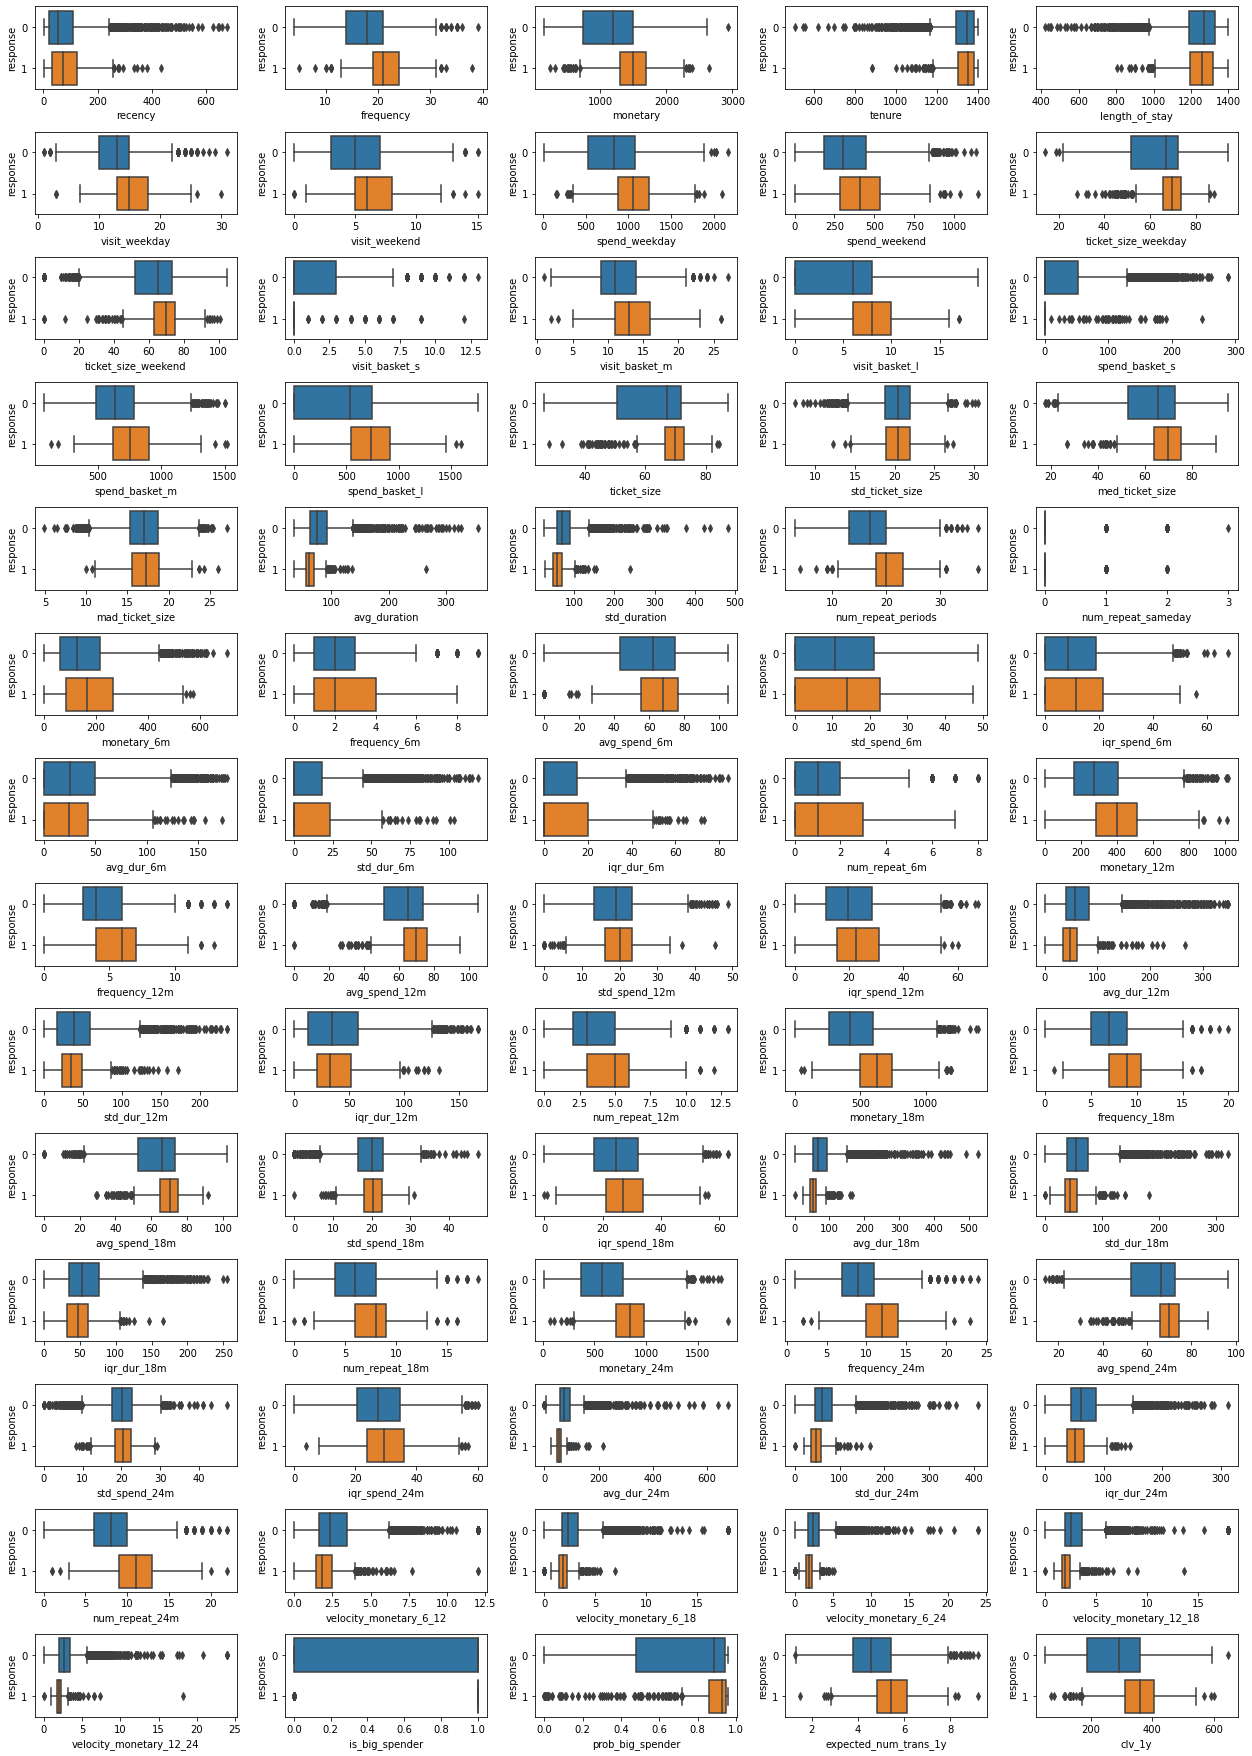

In [ ]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3.5, n_rows*1.75), tight_layout=True)
axes = axes.ravel()
for col, ax in zip(df.columns[1:], axes):
    sns.boxplot(data=df, y='response', x=col, ax=ax, orient='h')
plt.show()

[0.37083501 0.0997176 ]


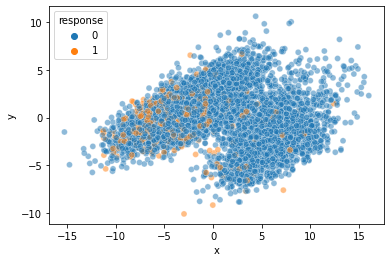

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

X = df.drop(['response'],axis=1)
X_std = scale(X)

pca = PCA(2)
embed = pca.fit_transform(X_std)
print(pca.explained_variance_ratio_)
sns.scatterplot(data=pd.DataFrame({'x':embed[:,0],'y':embed[:,1],'response':df['response']}), x='x', y='y', hue='response', alpha=.5);

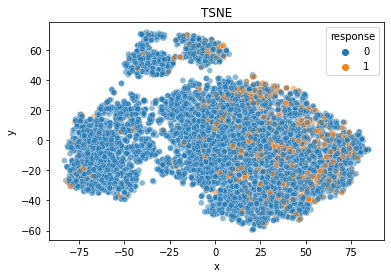

In [ ]:
from sklearn.manifold import TSNE
embed_tsne = TSNE(2).fit_transform(X_std)
sns.scatterplot(data=pd.DataFrame({'x':embed_tsne[:,0],'y':embed_tsne[:,1],'response':df['response']}), x='x', y='y', hue='response', alpha=.5)
plt.title('TSNE');

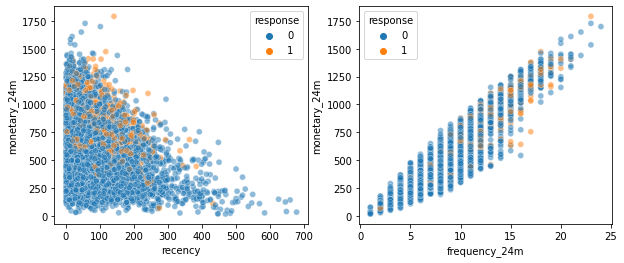

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
sns.scatterplot(data=df, x='recency', y='monetary_24m', hue='response', alpha=.5, ax=axes[0])
sns.scatterplot(data=df, x='frequency_24m', y='monetary_24m', hue='response', alpha=.5, ax=axes[1])
# sns.scatterplot(data=df, x='avg_dur_24m', y='velocity_monetary_12_24', hue='response', alpha=.5, ax=axes[2])
plt.show()

# 1st Evaluation 

All features with resamplings.

In [99]:
from imblearn.pipeline import Pipeline, make_pipeline

undersampler = RandomUnderSampler(random_state=random_state)
oversampler = RandomOverSampler(random_state=random_state)
smote = SMOTE(random_state=random_state)
smote_tomek = SMOTETomek(random_state=random_state)
smote_enn = SMOTEENN(random_state=random_state)

resamplers = [
    ('n/a', None),
    ('undersampler', undersampler),
    ('oversampler', oversampler),
    ('smote', smote),
    ('smote-tomek', smote_tomek),
    ('smote-enn', smote_enn)
]

kf = StratifiedKFold(n_splits=5)

metric_cols = ['model','resampler','cv-train-mean','cv-train-std','cv-val-mean','cv-val-std','test']

def display_metrics(df):
    return df.style.bar(subset=['cv-train-mean'], color='lightskyblue')\
                    .bar(subset=['cv-val-mean'], color='lightsalmon')\
                    .bar(subset=['cv-train-std','cv-val-std'], color='lightgray')\
                    .bar(subset=['test'], color='lightgreen')\
                    .format({'cv-train-mean':'{:.2%}','cv-val-mean':'{:.2%}','cv-train-std':'{:.2%}','cv-val-std':'{:.2%}','train':'{:.2%}', 'val':'{:.2%}', 'test':'{:.2%}'})

def get_resample(x, y, resampler=None):
    """
    Exepcted x, y as DataFrame and Series
    """
    if resampler:
        x_rs, y_rs = resampler.fit_resample(x, y)
        x_rs = pd.DataFrame(x_rs, columns=x.columns) 
        y_rs = pd.Series(y_rs, name=y.name)
    else:
        x_rs, y_rs = x, y
    return x_rs, y_rs

## Train-Valid-Test Sets

In [106]:
test_size = 0.3
valid_size = 0.2

drop_list = ['num_repeat_periods','num_repeat_sameday','num_repeat_6m','num_repeat_12m','num_repeat_18m','num_repeat_24m',
             'expected_num_trans_1y','clv_1y']

X = df.drop(['response'] + drop_list, axis=1)
y = df['response']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, 
                                                    random_state=random_state, stratify=y)

X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size= valid_size/(1-test_size), 
                                                        random_state=55, stratify=y_train)

print(f"Train: {X_train2.shape}, Size: {X_train2.shape[0]/X.shape[0]:.2%}, Positive: {y_train2.mean():.2%}")
print(f"Valid: {X_val.shape}, Size: {X_val.shape[0]/X.shape[0]:.2%}, Positive: {y_val.mean():.2%}")
print(f"Test : {X_test.shape}, Size: {X_test.shape[0]/X.shape[0]:.2%}, Positive: {y_test.mean():.2%}")

Train: (3441, 62), Size: 49.99%, Positive: 9.42%
Valid: (1377, 62), Size: 20.00%, Positive: 9.37%
Test : (2066, 62), Size: 30.01%, Positive: 9.39%


## Logistic Regression

In [107]:
model_name = 'LogisticRegression - All'
logreg_params = {
    'solver': 'liblinear',
    'class_weight': 'balanced',
    'random_state': random_state,
}

def logreg_cross_val_score(params,  cv, resampler=None):
    """
    Cross validate LogReg model. Resample only the train set for each fold
    """
    train_scores = []
    val_scores = []
    for train_fold_index, val_fold_index in cv.split(X_train, y_train):
        X_train_fold, y_train_fold = X_train.iloc[train_fold_index], y_train[train_fold_index]
        X_val_fold, y_val_fold = X_train.iloc[val_fold_index], y_train[val_fold_index]

        X_train_rs, y_train_rs = get_resample(X_train_fold, y_train_fold, resampler)

        model = LogisticRegression(**params)
        model.fit(X_train_rs, y_train_rs)

        auc_train = roc_auc_score(y_train_rs, model.decision_function(X_train_rs))
        auc_val = roc_auc_score(y_val_fold, model.decision_function(X_val_fold))

        train_scores.append(auc_train)
        val_scores.append(auc_val)
    return train_scores, val_scores

def logreg_eval_score(params, resampler=None):
    
    X_train_rs, y_train_rs = get_resample(X_train2, y_train2, resampler)

    model = LogisticRegression(**params)
    model.fit(X_train_rs, y_train_rs)

    auc_train = roc_auc_score(y_train_rs, model.decision_function(X_train_rs))
    auc_val = roc_auc_score(y_val, model.decision_function(X_val))
    auc_test = roc_auc_score(y_test, model.decision_function(X_test))
    return auc_train, auc_val, auc_test

result = []
for rs_name, rs in resamplers:
    train_scores, val_scores = logreg_cross_val_score(logreg_params, resampler=rs, cv=kf)
    auc_train, auc_val, auc_test = logreg_eval_score(logreg_params, resampler=rs)
    result.append((model_name, rs_name, 
                   np.mean(train_scores), np.std(train_scores),
                   np.mean(val_scores), np.std(val_scores),
                   auc_test))

logreg_result = pd.DataFrame(result, columns=metric_cols)
display_metrics(logreg_result)

,model,resampler,cv-train-mean,cv-train-std,cv-val-mean,cv-val-std,test
0,LogisticRegression - All,n/a,81.46%,0.67%,78.61%,2.34%,74.43%
1,LogisticRegression - All,undersampler,82.55%,0.80%,77.76%,2.38%,70.67%
2,LogisticRegression - All,oversampler,81.65%,0.69%,78.62%,2.18%,74.29%
3,LogisticRegression - All,smote,82.96%,0.79%,78.24%,2.66%,73.84%
4,LogisticRegression - All,smote-tomek,83.03%,0.82%,78.22%,2.62%,73.91%
5,LogisticRegression - All,smote-enn,91.66%,0.70%,78.62%,2.93%,74.46%


## XGBoost

In [108]:
model_name = 'XGBoost - All'
xgb_params = {'objective':'binary:logistic', 'random_state':random_state, 
              'eval_metric':'auc',
              'colsample_bytree': 0.65, 'learning_rate': 0.03,
              'max_depth': 3, 'reg_alpha': 21, 'reg_lambda':12,'gamma':1,
              'n_estomators':500, }

fit_params={'early_stopping_rounds': 10, 
        'eval_metric': 'auc',
    'verbose': False, }

def xgb_cross_val_score(params, cv, resampler=None):    
    train_scores = []
    val_scores = []
    for train_fold_index, val_fold_index in cv.split(X_train, y_train):
        X_train_fold, y_train_fold = X_train.iloc[train_fold_index], y_train[train_fold_index]
        X_val_fold, y_val_fold = X_train.iloc[val_fold_index], y_train[val_fold_index]

        X_train_rs, y_train_rs = get_resample(X_train_fold, y_train_fold, resampler)

        scale_pos_weight = (len(y_train_rs) - sum(y_train_rs)) / sum(y_train_rs)
        eval_set=[(X_train_rs, y_train_rs), (X_val_fold, y_val_fold)]

        model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, **params)
        model = model.fit(X_train_rs, y_train_rs, eval_set=eval_set,
                          early_stopping_rounds=50, eval_metric='auc', verbose=False)
        
        auc_train = roc_auc_score(y_train_rs, model.predict_proba(X_train_rs)[:,1])
        auc_val = roc_auc_score(y_val_fold, model.predict_proba(X_val_fold)[:,1])

        train_scores.append(auc_train)
        val_scores.append(auc_val)
    return train_scores, val_scores

def xgb_eval_score(params, resampler=None):

    X_train_rs, y_train_rs = get_resample(X_train2, y_train2, resampler)

    scale_pos_weight = (len(y_train_rs) - sum(y_train_rs)) / sum(y_train_rs)
    eval_set=[(X_train_rs, y_train_rs), (X_val, y_val)]

    model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, **params)
    model = model.fit(X_train_rs, y_train_rs, eval_set=eval_set,
                        early_stopping_rounds=50, eval_metric='auc', verbose=False)

    auc_train = roc_auc_score(y_train_rs, model.predict_proba(X_train_rs)[:,1])
    auc_val = roc_auc_score(y_val, model.predict_proba(X_val)[:,1])
    auc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    return auc_train, auc_val, auc_test

result = []
for rs_name, rs in resamplers:
    train_scores, val_scores = xgb_cross_val_score(xgb_params, resampler=rs, cv=kf)
    auc_train, auc_val, auc_test = xgb_eval_score(xgb_params, resampler=rs)
    result.append((model_name, rs_name, 
                   np.mean(train_scores), np.std(train_scores),
                   np.mean(val_scores), np.std(val_scores),
                   auc_test))
    
xgb_result = pd.DataFrame(result, columns=metric_cols)
display_metrics(xgb_result)

,model,resampler,cv-train-mean,cv-train-std,cv-val-mean,cv-val-std,test
0,XGBoost - All,n/a,84.85%,0.62%,80.91%,2.41%,77.15%
1,XGBoost - All,undersampler,83.71%,0.62%,79.65%,1.99%,77.02%
2,XGBoost - All,oversampler,84.95%,0.96%,80.79%,2.38%,76.76%
3,XGBoost - All,smote,88.21%,2.27%,80.47%,1.92%,77.36%
4,XGBoost - All,smote-tomek,87.66%,1.95%,80.59%,1.94%,77.16%
5,XGBoost - All,smote-enn,94.21%,0.26%,80.46%,1.97%,78.09%


## LightGBM

In [109]:
model_name = 'LightGBM - All'
lgb_params = {
    'objective': 'binary', 'random_state':  random_state, 'is_unbalance': 'true',
    'metric': 'auc',
    'lambda_l1': 0.0010653894836762862, 
    'lambda_l2': 1.5642139864332834, 
    'num_leaves': 111, 
    'feature_fraction': 0.8170433061856316, 
    'bagging_fraction': 0.4759610775176239, 
    'bagging_freq': 6, 
    'min_child_samples': 96, 
    'learning_rate': 0.006499690038601971,
    'verbose': -1,
}

def lgb_cross_val_score(params, cv, resampler=None):
    train_scores = []
    val_scores = []
    for train_fold_index, val_fold_index in cv.split(X_train, y_train):
        X_train_fold, y_train_fold = X_train.iloc[train_fold_index], y_train[train_fold_index]
        X_val_fold, y_val_fold = X_train.iloc[val_fold_index], y_train[val_fold_index]

        X_train_rs, y_train_rs = get_resample(X_train_fold, y_train_fold, resampler)

        train_data = lgb.Dataset(X_train_rs, label=y_train_rs)
        val_data = lgb.Dataset(X_val_fold, label=y_val_fold)

        model = lgb.train(params, train_data, valid_sets=[val_data,train_data], num_boost_round=5000, 
                          early_stopping_rounds=50, verbose_eval=False)
    
        auc_train = roc_auc_score(y_train_rs, model.predict(X_train_rs))
        auc_val = roc_auc_score(y_val_fold, model.predict(X_val_fold))

        train_scores.append(auc_train)
        val_scores.append(auc_val)
    return train_scores, val_scores

def lgb_eval_score(params, resampler=None):
    
    X_train_rs, y_train_rs = get_resample(X_train2, y_train2, resampler)

    train_data = lgb.Dataset(X_train_rs, label=y_train_rs)
    val_data = lgb.Dataset(X_val, label=y_val)

    model = lgb.train(params, train_data, valid_sets=[val_data,train_data], num_boost_round=5000, 
                      early_stopping_rounds=50, verbose_eval=False)

    auc_train = roc_auc_score(y_train_rs, model.predict(X_train_rs))
    auc_val = roc_auc_score(y_val, model.predict(X_val))
    auc_test = roc_auc_score(y_test, model.predict(X_test))
    return auc_train, auc_val, auc_test


result = []
for rs_name, rs in resamplers:
    train_scores, val_scores = lgb_cross_val_score(lgb_params, resampler=rs, cv=kf)
    auc_train, auc_val, auc_test = lgb_eval_score(lgb_params, resampler=rs)
    result.append((model_name, rs_name, 
                   np.mean(train_scores), np.std(train_scores),
                   np.mean(val_scores), np.std(val_scores),
                   auc_test))

lgb_result = pd.DataFrame(result, columns=metric_cols)
display_metrics(lgb_result)

,model,resampler,cv-train-mean,cv-train-std,cv-val-mean,cv-val-std,test
0,LightGBM - All,n/a,85.27%,1.88%,80.73%,2.49%,77.17%
1,LightGBM - All,undersampler,81.39%,0.50%,79.94%,2.22%,76.22%
2,LightGBM - All,oversampler,89.79%,0.40%,80.41%,2.43%,76.29%
3,LightGBM - All,smote,93.91%,0.61%,79.92%,1.63%,76.90%
4,LightGBM - All,smote-tomek,93.19%,0.86%,80.53%,2.23%,77.34%
5,LightGBM - All,smote-enn,94.93%,0.64%,80.63%,2.22%,78.16%


## Summary - 1st Round

In [110]:
summary = pd.concat([logreg_result, xgb_result, lgb_result]).reset_index()
display_metrics(summary.sort_values(['test','cv-val-mean'],ascending=False))

,index,model,resampler,cv-train-mean,cv-train-std,cv-val-mean,cv-val-std,test
17,5,LightGBM - All,smote-enn,94.93%,0.64%,80.63%,2.22%,78.16%
11,5,XGBoost - All,smote-enn,94.21%,0.26%,80.46%,1.97%,78.09%
9,3,XGBoost - All,smote,88.21%,2.27%,80.47%,1.92%,77.36%
16,4,LightGBM - All,smote-tomek,93.19%,0.86%,80.53%,2.23%,77.34%
12,0,LightGBM - All,n/a,85.27%,1.88%,80.73%,2.49%,77.17%
10,4,XGBoost - All,smote-tomek,87.66%,1.95%,80.59%,1.94%,77.16%
6,0,XGBoost - All,n/a,84.85%,0.62%,80.91%,2.41%,77.15%
7,1,XGBoost - All,undersampler,83.71%,0.62%,79.65%,1.99%,77.02%
15,3,LightGBM - All,smote,93.91%,0.61%,79.92%,1.63%,76.90%
8,2,XGBoost - All,oversampler,84.95%,0.96%,80.79%,2.38%,76.76%


# Feature Selection

## Recursive Feature Elimination

### RFE using XGBoost

In [111]:
from sklearn.feature_selection import RFE
from sklearn.preprocessing import scale

scale_pos_weight = (len(y) - sum(y)) / sum(y)
num_features = 20

X_std = scale(X)

# rfe_selector = RFE(estimator=LogisticRegression(solver='liblinear', class_weight='balanced', random_state=random_state), 
#                    n_features_to_select=num_features, step=1, verbose=5)
rfe_selector = RFE(estimator=xgb.XGBClassifier(objective ='binary:logistic', 
                                               random_state=random_state, scale_pos_weight=scale_pos_weight, n_estimators=500, metric='auc'),
                   n_features_to_select=num_features, step=1, verbose=5)
# rfe_selector.fit(X_std, y)
rfe_selector.fit(X, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')
rfe_feature

Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 fe

['recency',
 'monetary',
 'length_of_stay',
 'spend_basket_l',
 'avg_duration',
 'frequency_6m',
 'frequency_12m',
 'avg_spend_12m',
 'monetary_18m',
 'frequency_18m',
 'avg_dur_18m',
 'iqr_dur_18m',
 'monetary_24m',
 'frequency_24m',
 'avg_dur_24m',
 'velocity_monetary_6_12',
 'velocity_monetary_6_18',
 'velocity_monetary_6_24',
 'velocity_monetary_12_18',
 'velocity_monetary_12_24']

### RFE using LightGBM

In [114]:
from lightgbm import LGBMClassifier

lgbc = LGBMClassifier(is_unbalance=True, metric='auc', random_state=random_state)

rfe2_selector = RFE(estimator=lgbc, n_features_to_select=num_features, step=1, verbose=5)
rfe2_selector.fit(X, y)
rfe2_support = rfe2_selector.get_support()
rfe2_feature = X.loc[:,rfe2_support].columns.tolist()
print(str(len(rfe2_feature)), 'selected features')
rfe2_feature

Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 fe

['recency',
 'length_of_stay',
 'spend_weekend',
 'ticket_size_weekday',
 'ticket_size_weekend',
 'spend_basket_m',
 'std_ticket_size',
 'avg_spend_12m',
 'iqr_spend_12m',
 'iqr_dur_12m',
 'iqr_spend_18m',
 'avg_dur_18m',
 'std_dur_18m',
 'iqr_dur_18m',
 'monetary_24m',
 'std_spend_24m',
 'avg_dur_24m',
 'iqr_dur_24m',
 'velocity_monetary_6_12',
 'velocity_monetary_12_24']

## Lasso

In [115]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

lasso_selector = SelectFromModel(LogisticRegression(solver='liblinear', class_weight='balanced', penalty="l1", random_state=random_state), 
                                 max_features=num_features)
lasso_selector.fit(X_std, y)

lasso_support = lasso_selector.get_support()
lasso_feature = X.loc[:,lasso_support].columns.tolist()
print(str(len(lasso_feature)), 'selected features')
lasso_feature

20 selected features


['recency',
 'frequency',
 'ticket_size_weekday',
 'spend_basket_l',
 'std_ticket_size',
 'mad_ticket_size',
 'monetary_6m',
 'avg_spend_6m',
 'iqr_dur_6m',
 'monetary_12m',
 'frequency_12m',
 'avg_spend_12m',
 'monetary_18m',
 'frequency_18m',
 'avg_spend_18m',
 'avg_dur_18m',
 'frequency_24m',
 'avg_spend_24m',
 'std_dur_24m',
 'velocity_monetary_6_24']

## Tree-based

### RandomForest selector

In [120]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=500, random_state=random_state), max_features=num_features)
rf_selector.fit(X, y)

rf_support = rf_selector.get_support()
rf_feature = X.loc[:,rf_support].columns.tolist()
print(str(len(rf_feature)), 'selected features')
rf_feature

20 selected features


['recency',
 'monetary',
 'length_of_stay',
 'spend_basket_m',
 'std_ticket_size',
 'mad_ticket_size',
 'avg_duration',
 'std_duration',
 'monetary_12m',
 'monetary_18m',
 'avg_dur_18m',
 'std_dur_18m',
 'monetary_24m',
 'frequency_24m',
 'avg_dur_24m',
 'std_dur_24m',
 'iqr_dur_24m',
 'velocity_monetary_6_24',
 'velocity_monetary_12_18',
 'velocity_monetary_12_24']

### ExtraTree selector

In [121]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier

et_selector = SelectFromModel(ExtraTreesClassifier(n_estimators=500, random_state=random_state), max_features=num_features)
et_selector.fit(X, y)

et_support = et_selector.get_support()
et_feature = X.loc[:,et_support].columns.tolist()
print(str(len(et_feature)), 'selected features')
et_feature

20 selected features


['recency',
 'frequency',
 'monetary',
 'length_of_stay',
 'spend_basket_m',
 'avg_duration',
 'std_duration',
 'monetary_12m',
 'monetary_18m',
 'frequency_18m',
 'avg_dur_18m',
 'std_dur_18m',
 'monetary_24m',
 'frequency_24m',
 'avg_dur_24m',
 'std_dur_24m',
 'iqr_dur_24m',
 'velocity_monetary_6_24',
 'velocity_monetary_12_18',
 'velocity_monetary_12_24']

### XGBoost selector

In [122]:
xgb_selector = SelectFromModel(xgb.XGBClassifier(objective ='binary:logistic', random_state=random_state,
                                                 scale_pos_weight=scale_pos_weight, n_estimators=500, metric='auc'), max_features=num_features)
xgb_selector.fit(X, y)

xgb_support = xgb_selector.get_support()
xgb_feature = X.loc[:,xgb_support].columns.tolist()
print(str(len(xgb_feature)), 'selected features')
xgb_feature

10 selected features


['recency',
 'visit_basket_l',
 'avg_duration',
 'frequency_18m',
 'monetary_24m',
 'frequency_24m',
 'avg_dur_24m',
 'velocity_monetary_6_18',
 'velocity_monetary_6_24',
 'velocity_monetary_12_24']

### LightGBM selector

In [123]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

lgbc = LGBMClassifier(is_unbalance=True, metric='auc', random_state=random_state)

lgb_selector = SelectFromModel(lgbc, max_features=num_features)
lgb_selector.fit(X, y)

lgb_support = lgb_selector.get_support()
lgb_feature = X.loc[:,lgb_support].columns.tolist()
print(str(len(lgb_feature)), 'selected features')
lgb_feature

20 selected features


['recency',
 'length_of_stay',
 'spend_weekend',
 'ticket_size_weekday',
 'ticket_size_weekend',
 'spend_basket_m',
 'std_ticket_size',
 'std_spend_12m',
 'avg_dur_12m',
 'iqr_dur_12m',
 'iqr_spend_18m',
 'avg_dur_18m',
 'std_dur_18m',
 'iqr_dur_18m',
 'monetary_24m',
 'std_spend_24m',
 'iqr_spend_24m',
 'avg_dur_24m',
 'std_dur_24m',
 'iqr_dur_24m']

## SequentialFeatureSelector

New stuff from sklearn 2.4, but it takes very long. Let's just skip this.

In [ ]:
# from sklearn.feature_selection import SequentialFeatureSelector

# # scale_pos_weight = (len(y) - sum(y)) / sum(y)
# # LogisticRegression(solver='liblinear', class_weight='balanced', random_state=random_state)
# # sfs_selector = SequentialFeatureSelector(estimator=xgb.XGBClassifier(scale_pos_weight=scale_pos_weight), 
# #                                          n_features_to_select=num_features, cv=5, direction='backward', scoring='roc_auc')
# sfs_selector = SequentialFeatureSelector(estimator=LogisticRegression(solver='liblinear', class_weight='balanced', random_state=random_state),
#                                          n_features_to_select=num_features, cv=5, direction='backward', scoring='roc_auc')

# sfs_selector.fit(X_std, y)
# sfs_support = sfs_selector.get_support()

# sfs_feature = X.loc[:,sfs_support].columns.tolist()
# print(str(len(sfs_feature)), 'selected features')
# sfs_feature

25 selected features


['recency',
 'tenure',
 'length_of_stay',
 'visit_weekend',
 'spend_weekday',
 'ticket_size_weekday',
 'visit_basket_l',
 'spend_basket_l',
 'std_ticket_size',
 'med_ticket_size',
 'recency_score',
 'iqr_spend_6m',
 'avg_dur_6m',
 'frequency_12m',
 'std_spend_12m',
 'iqr_spend_12m',
 'monetary_18m',
 'avg_spend_18m',
 'avg_dur_18m',
 'frequency_24m',
 'std_dur_24m',
 'velocity_monetary_6_12',
 'velocity_monetary_6_24',
 'prob_big_spender',
 'expected_num_trans_1y']

## Feature Voting

In [124]:
feature_df = pd.DataFrame({ 'feature': X.columns})

feature_df['RFE-XGB'] = feature_df['feature'].isin(rfe_feature)
feature_df['RFE-LGB'] = feature_df['feature'].isin(rfe2_feature)
feature_df['Lasso'] = feature_df['feature'].isin(lasso_feature)
feature_df['RF'] = feature_df['feature'].isin(rf_feature)
feature_df['ET'] = feature_df['feature'].isin(et_feature)
feature_df['XGB'] = feature_df['feature'].isin(xgb_feature)
feature_df['LGBM'] = feature_df['feature'].isin(lgb_feature)
feature_df['Total'] = feature_df.sum(axis=1)
feature_df[feature_df['Total']>0].sort_values('Total', ascending=False)

,feature,RFE-XGB,RFE-LGB,Lasso,RF,ET,XGB,LGBM,Total
0,recency,True,True,True,True,True,True,True,7
44,avg_dur_18m,True,True,True,True,True,False,True,6
52,avg_dur_24m,True,True,False,True,True,True,True,6
47,monetary_24m,True,True,False,True,True,True,True,6
57,velocity_monetary_6_24,True,False,True,True,True,True,False,5
48,frequency_24m,True,False,True,True,True,True,False,5
59,velocity_monetary_12_24,True,True,False,True,True,True,False,5
4,length_of_stay,True,True,False,True,True,False,True,5
40,frequency_18m,True,False,True,False,True,True,False,4
53,std_dur_24m,False,False,True,True,True,False,True,4


In [125]:
fieldset = feature_df[feature_df.Total > 3].feature.values
fieldset

array(['recency', 'length_of_stay', 'spend_basket_m', 'std_ticket_size',
       'avg_duration', 'monetary_18m', 'frequency_18m', 'avg_dur_18m',
       'std_dur_18m', 'monetary_24m', 'frequency_24m', 'avg_dur_24m',
       'std_dur_24m', 'iqr_dur_24m', 'velocity_monetary_6_24',
       'velocity_monetary_12_24'], dtype=object)

# 2nd Evaluation

Feature selection with resamplings

## Train-Valid-Test Sets

In [208]:
# manual select
# fieldset = ['recency','avg_duration','visit_basket_l',
#             'frequency_24m','monetary_24m','avg_dur_24m','std_dur_24m',
#             'frequency_18m','monetary_18m','avg_dur_18m','std_dur_18m',
#              'velocity_monetary_12_24', 'velocity_monetary_6_18','velocity_monetary_6_24']

# fieldset = ['recency','avg_duration','visit_basket_l',
#             'frequency_24m','monetary_24m','avg_dur_24m','std_dur_24m',
#             'frequency_18m','monetary_18m','avg_dur_18m','std_dur_18m',
#              'velocity_monetary_12_24', 'velocity_monetary_6_18','velocity_monetary_6_24']

# fieldset = ['recency','length_of_stay', 'avg_duration', 'std_ticket_size',
# 	        'visit_basket_l',
#             'frequency_24m','monetary_24m','avg_dur_24m','std_dur_24m',
#             'frequency_18m','monetary_18m','avg_dur_18m','std_dur_18m',
#              'velocity_monetary_6_18', 'velocity_monetary_6_24','velocity_monetary_12_24',]

fieldset = ['recency','length_of_stay', 'avg_duration', 'std_ticket_size',
            'frequency_24m','monetary_24m','std_spend_24m','avg_dur_24m','std_dur_24m',
            'frequency_18m','monetary_18m','std_spend_18m','avg_dur_18m','std_dur_18m',
            'velocity_monetary_6_18', 'velocity_monetary_6_24','velocity_monetary_12_24',
            ]

test_size = 0.3
valid_size = 0.2

X = df[fieldset].copy()
y = df['response']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, 
                                                    random_state=random_state, stratify=y)

X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size= valid_size/(1-test_size), 
                                                        random_state=55, stratify = y_train)

print(f"Train: {X_train2.shape}, Size: {X_train2.shape[0]/X.shape[0]:.2%}, Positive: {y_train2.mean():.2%}")
print(f"Valid: {X_val.shape}, Size: {X_val.shape[0]/X.shape[0]:.2%}, Positive: {y_val.mean():.2%}")
print(f"Test : {X_test.shape}, Size: {X_test.shape[0]/X.shape[0]:.2%}, Positive: {y_test.mean():.2%}")

Train: (3441, 17), Size: 49.99%, Positive: 9.42%
Valid: (1377, 17), Size: 20.00%, Positive: 9.37%
Test : (2066, 17), Size: 30.01%, Positive: 9.39%


## Logistic Regression

In [209]:
model_name = 'LogisticRegression - Sub'
result = []
for rs_name, rs in resamplers:
    train_scores, val_scores = logreg_cross_val_score(logreg_params, resampler=rs, cv=kf)
    auc_train, auc_val, auc_test = logreg_eval_score(logreg_params, resampler=rs)
    result.append((model_name, rs_name, 
                   np.mean(train_scores), np.std(train_scores),
                   np.mean(val_scores), np.std(val_scores),
                   auc_test))

logreg2_result = pd.DataFrame(result, columns=metric_cols)

In [210]:
display_metrics(pd.concat([logreg_result,logreg2_result]).set_index(['model','resampler']))

## XGBoost

In [211]:
model_name = 'XGBoost - Sub'
result = []
for rs_name, rs in resamplers:
    train_scores, val_scores = xgb_cross_val_score(xgb_params, resampler=rs, cv=kf)
    auc_train, auc_val, auc_test = xgb_eval_score(xgb_params, resampler=rs)
    result.append((model_name, rs_name, 
                   np.mean(train_scores), np.std(train_scores),
                   np.mean(val_scores), np.std(val_scores),
                   auc_test))
    
xgb2_result = pd.DataFrame(result, columns=metric_cols)

In [212]:
display_metrics(pd.concat([xgb_result,xgb2_result]).set_index(['model','resampler']))

## LightGBM

In [213]:
model_name = 'LightGBM - Sub'
result = []
for rs_name, rs in resamplers:
    train_scores, val_scores = lgb_cross_val_score(lgb_params, resampler=rs, cv=kf)
    auc_train, auc_val, auc_test = lgb_eval_score(lgb_params, resampler=rs)
    result.append((model_name, rs_name, 
                   np.mean(train_scores), np.std(train_scores),
                   np.mean(val_scores), np.std(val_scores),
                   auc_test))

lgb2_result = pd.DataFrame(result, columns=metric_cols)

In [214]:
display_metrics(pd.concat([lgb_result,lgb2_result]).set_index(['model','resampler']))

## Summary - 2nd Round

In [215]:
summary = pd.concat([logreg_result, xgb_result, lgb_result, logreg2_result, xgb2_result, lgb2_result]).reset_index(drop=True)
display_metrics(summary.sort_values(['test','cv-val-mean'], ascending=False))

,model,resampler,cv-train-mean,cv-train-std,cv-val-mean,cv-val-std,test
28,XGBoost - Sub,smote-tomek,87.71%,1.14%,80.59%,2.12%,78.52%
29,XGBoost - Sub,smote-enn,93.76%,0.29%,80.63%,2.08%,78.40%
35,LightGBM - Sub,smote-enn,94.02%,0.70%,80.62%,2.19%,78.31%
17,LightGBM - All,smote-enn,94.93%,0.64%,80.63%,2.22%,78.16%
11,XGBoost - All,smote-enn,94.21%,0.26%,80.46%,1.97%,78.09%
27,XGBoost - Sub,smote,86.32%,1.18%,80.63%,2.15%,77.85%
33,LightGBM - Sub,smote,90.20%,1.47%,80.70%,2.84%,77.76%
24,XGBoost - Sub,n/a,84.22%,0.55%,80.88%,2.32%,77.47%
30,LightGBM - Sub,n/a,84.47%,0.90%,80.81%,2.45%,77.44%
9,XGBoost - All,smote,88.21%,2.27%,80.47%,1.92%,77.36%


# Model Tuning

In [216]:
!pip install optuna

     |████████████████████████████████| 296kB 8.6MB/s 
     |████████████████████████████████| 174kB 16.4MB/s 
     |████████████████████████████████| 81kB 8.7MB/s 
     |████████████████████████████████| 81kB 9.8MB/s 
     |████████████████████████████████| 143kB 16.7MB/s 
     |████████████████████████████████| 112kB 17.6MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11107 sha256=77cd9d4437049b3f77dc19f5ff7720a36ead80e2c4ff6d64ae7f77616a3c308c
  Stored in directory: /root/.cache/pip/wheels/25/af/b8/3407109267803f4015e1ee2ff23be0c8c19ce4008665931ee1
Successfully built pyperclip


In [ ]:
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import joblib

## XGBoost + No Resampling

In [259]:
def objective(trial: Trial, X, y) -> float:
    joblib.dump(study, 'study.pkl')

    param = {
        'n_estimators' : trial.suggest_int('n_estimators', 0, 1500),
        'max_depth' : trial.suggest_int('max_depth', 2, 30),
        'reg_alpha' : trial.suggest_int('reg_alpha', 0, 30),
        'reg_lambda' : trial.suggest_int('reg_lambda', 0, 30),
        'min_child_weight' : trial.suggest_int('min_child_weight', 0, 10),
        'gamma' : trial.suggest_int('gamma', 0, 10),
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.005, 0.7),
        'colsample_bytree' : trial.suggest_discrete_uniform('colsample_bytree',0.1 ,1, 0.01),
        'nthread' : -1,
        'random_state' : random_state
    }

    train_scores, val_scores = xgb_cross_val_score(param, resampler=None, cv=kf)
    return np.mean(val_scores)

study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=50)
print(f"Best trial: score {study.best_trial.value},\nparams {study.best_trial.params}")

[I 2021-05-29 11:00:29,528] A new study created in memory with name: no-name-5e64fb3d-f402-458a-abc1-01f0e3bfd4e2
[I 2021-05-29 11:00:33,817] Trial 0 finished with value: 0.8041211658393788 and parameters: {'n_estimators': 530, 'max_depth': 22, 'reg_alpha': 6, 'reg_lambda': 24, 'min_child_weight': 5, 'gamma': 4, 'learning_rate': 0.0409157940271687, 'colsample_bytree': 0.47}. Best is trial 0 with value: 0.8041211658393788.
[I 2021-05-29 11:00:39,434] Trial 1 finished with value: 0.7975549065927073 and parameters: {'n_estimators': 975, 'max_depth': 18, 'reg_alpha': 1, 'reg_lambda': 30, 'min_child_weight': 2, 'gamma': 3, 'learning_rate': 0.021747399833219844, 'colsample_bytree': 0.67}. Best is trial 0 with value: 0.8041211658393788.
[I 2021-05-29 11:00:45,470] Trial 2 finished with value: 0.7991672995453063 and parameters: {'n_estimators': 1432, 'max_depth': 27, 'reg_alpha': 1, 'reg_lambda': 16, 'min_child_weight': 0, 'gamma': 5, 'learning_rate': 0.06356082440526191, 'colsample_bytree': 0

Best trial: score 0.8104104550152661,
params {'n_estimators': 1483, 'max_depth': 2, 'reg_alpha': 28, 'reg_lambda': 28, 'min_child_weight': 2, 'gamma': 4, 'learning_rate': 0.10402708455639181, 'colsample_bytree': 0.75}


In [267]:
params = {'n_estimators': 1483, 'max_depth': 2, 'reg_alpha': 28, 'reg_lambda': 28, 'min_child_weight': 2, 'gamma': 4, 'learning_rate': 0.10402708455639181, 'colsample_bytree': 0.75}
params['random_state'] = random_state

auc_train, auc_val, auc_test = xgb_eval_score(params, resampler=None)
auc_train, auc_val, auc_test

(0.8352998490951651, 0.8144286672629697, 0.7786506520398273)

## XGBoost + SMOTE

In [265]:
def objective(trial: Trial, X, y) -> float:
    # joblib.dump(study, 'study.pkl')

    param = {
        'n_estimators' : trial.suggest_int('n_estimators', 0, 1500),
        'max_depth' : trial.suggest_int('max_depth', 2, 30),
        'reg_alpha' : trial.suggest_int('reg_alpha', 0, 30),
        'reg_lambda' : trial.suggest_int('reg_lambda', 0, 30),
        'min_child_weight' : trial.suggest_int('min_child_weight', 0, 10),
        'gamma' : trial.suggest_int('gamma', 0, 10),
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.005, 0.7),
        'colsample_bytree' : trial.suggest_discrete_uniform('colsample_bytree',0.1 ,1, 0.01),
        'nthread' : -1,
        'random_state' : random_state,
    }

    train_scores, val_scores = xgb_cross_val_score(param, resampler=smote, cv=kf)
    return np.mean(val_scores)

study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=50)
print(f"Best trial: score {study.best_trial.value},\nparams {study.best_trial.params}")

[I 2021-05-29 11:05:59,065] A new study created in memory with name: no-name-08f1437a-77b7-4beb-8afc-e08320b90f6c
[I 2021-05-29 11:06:06,079] Trial 0 finished with value: 0.7989517571648157 and parameters: {'n_estimators': 298, 'max_depth': 4, 'reg_alpha': 29, 'reg_lambda': 18, 'min_child_weight': 7, 'gamma': 1, 'learning_rate': 0.018779150287151058, 'colsample_bytree': 0.23}. Best is trial 0 with value: 0.7989517571648157.
[I 2021-05-29 11:06:13,172] Trial 1 finished with value: 0.7982895912792821 and parameters: {'n_estimators': 899, 'max_depth': 13, 'reg_alpha': 15, 'reg_lambda': 18, 'min_child_weight': 5, 'gamma': 6, 'learning_rate': 0.17537018893068287, 'colsample_bytree': 0.41000000000000003}. Best is trial 0 with value: 0.7989517571648157.
[I 2021-05-29 11:06:21,273] Trial 2 finished with value: 0.803143231974847 and parameters: {'n_estimators': 311, 'max_depth': 28, 'reg_alpha': 24, 'reg_lambda': 11, 'min_child_weight': 10, 'gamma': 8, 'learning_rate': 0.03439003099273442, 'col

Best trial: score 0.8053656080460204,
params {'n_estimators': 965, 'max_depth': 17, 'reg_alpha': 27, 'reg_lambda': 28, 'min_child_weight': 8, 'gamma': 10, 'learning_rate': 0.07545838831803692, 'colsample_bytree': 0.32}


In [266]:
params = {'n_estimators': 965, 'max_depth': 17, 'reg_alpha': 27, 'reg_lambda': 28, 'min_child_weight': 8, 'gamma': 10, 'learning_rate': 0.07545838831803692, 'colsample_bytree': 0.32}
params['random_state'] = random_state

auc_train, auc_val, auc_test = xgb_eval_score(params, resampler=smote)
auc_train, auc_val, auc_test

(0.9221796827790597, 0.7977601371496721, 0.7804679927746939)

## XGBoost + SMOTE-TOMEK

In [268]:
# XGBoost + SMOTE-TOMEK Tuning
# Maximize - cross-validated score (mean of valdiation score)

def objective(trial: Trial, X, y) -> float:
    joblib.dump(study, 'study.pkl')

    param = {
        'n_estimators' : trial.suggest_int('n_estimators', 0, 1500),
        'max_depth' : trial.suggest_int('max_depth', 2, 30),
        'reg_alpha' : trial.suggest_int('reg_alpha', 0, 30),
        'reg_lambda' : trial.suggest_int('reg_lambda', 0, 30),
        'min_child_weight' : trial.suggest_int('min_child_weight', 0, 10),
        'gamma' : trial.suggest_int('gamma', 0, 10),
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.005, 0.7),
        'colsample_bytree' : trial.suggest_discrete_uniform('colsample_bytree',0.1 ,1, 0.01),
        'nthread' : -1,
        'random_state' : random_state,
    }

    train_scores, val_scores = xgb_cross_val_score(param, resampler=smote_tomek, cv=kf)
    return np.mean(val_scores)

study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=50)
print(f"Best trial: score {study.best_trial.value},\nparams {study.best_trial.params}")

[I 2021-05-29 11:12:53,454] A new study created in memory with name: no-name-7afc7720-8eb4-497d-a86c-cc49db429eea
[I 2021-05-29 11:12:59,099] Trial 0 finished with value: 0.7959671434585524 and parameters: {'n_estimators': 109, 'max_depth': 9, 'reg_alpha': 30, 'reg_lambda': 12, 'min_child_weight': 6, 'gamma': 6, 'learning_rate': 0.3272924800459703, 'colsample_bytree': 0.11}. Best is trial 0 with value: 0.7959671434585524.
[I 2021-05-29 11:13:08,421] Trial 1 finished with value: 0.7986695981884985 and parameters: {'n_estimators': 1192, 'max_depth': 19, 'reg_alpha': 5, 'reg_lambda': 14, 'min_child_weight': 10, 'gamma': 6, 'learning_rate': 0.1635869780233049, 'colsample_bytree': 0.61}. Best is trial 1 with value: 0.7986695981884985.
[I 2021-05-29 11:13:21,192] Trial 2 finished with value: 0.800786965357412 and parameters: {'n_estimators': 1166, 'max_depth': 18, 'reg_alpha': 14, 'reg_lambda': 30, 'min_child_weight': 9, 'gamma': 4, 'learning_rate': 0.0696982202658692, 'colsample_bytree': 0.

Best trial: score 0.8104267070590094,
params {'n_estimators': 500, 'max_depth': 2, 'reg_alpha': 21, 'reg_lambda': 0, 'min_child_weight': 2, 'gamma': 10, 'learning_rate': 0.020908568263150698, 'colsample_bytree': 1.0}


In [269]:
params = {'n_estimators': 500, 'max_depth': 2, 'reg_alpha': 21, 'reg_lambda': 0, 'min_child_weight': 2, 'gamma': 10, 'learning_rate': 0.020908568263150698, 'colsample_bytree': 1.0}
params['random_state'] = random_state
auc_train, auc_val, auc_test = xgb_eval_score(params, resampler=smote_tomek)
auc_train, auc_val, auc_test

(0.8730294170926518, 0.8054375372689326, 0.7846602674244427)

## XGBoost + SMOTE-ENN

In [270]:
def objective(trial: Trial, X, y) -> float:
    joblib.dump(study, 'study.pkl')

    param = {
        'n_estimators' : trial.suggest_int('n_estimators', 0, 1500),
        'max_depth' : trial.suggest_int('max_depth', 2, 30),
        'reg_alpha' : trial.suggest_int('reg_alpha', 0, 30),
        'reg_lambda' : trial.suggest_int('reg_lambda', 0, 30),
        'min_child_weight' : trial.suggest_int('min_child_weight', 0, 10),
        'gamma' : trial.suggest_int('gamma', 0, 10),
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.005, 0.7),
        'colsample_bytree' : trial.suggest_discrete_uniform('colsample_bytree',0.1 ,1, 0.01),
        'nthread' : -1,
        'random_state' : random_state,
    }

    train_scores, val_scores = xgb_cross_val_score(param, resampler=smote_enn, cv=kf)
    return np.mean(val_scores)

study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=50)
print(f"Best trial: score {study.best_trial.value},\nparams {study.best_trial.params}")

[I 2021-05-29 11:24:23,874] A new study created in memory with name: no-name-a8ded229-7155-4309-ab1e-e5945b059c4b
[I 2021-05-29 11:24:45,731] Trial 0 finished with value: 0.8059107927836451 and parameters: {'n_estimators': 1483, 'max_depth': 28, 'reg_alpha': 5, 'reg_lambda': 16, 'min_child_weight': 7, 'gamma': 7, 'learning_rate': 0.019024927635732953, 'colsample_bytree': 0.93}. Best is trial 0 with value: 0.8059107927836451.
[I 2021-05-29 11:24:57,776] Trial 1 finished with value: 0.8058572533486623 and parameters: {'n_estimators': 1103, 'max_depth': 17, 'reg_alpha': 28, 'reg_lambda': 7, 'min_child_weight': 5, 'gamma': 8, 'learning_rate': 0.08759824348101956, 'colsample_bytree': 0.84}. Best is trial 0 with value: 0.8059107927836451.
[I 2021-05-29 11:25:04,079] Trial 2 finished with value: 0.8051990036182477 and parameters: {'n_estimators': 1355, 'max_depth': 10, 'reg_alpha': 22, 'reg_lambda': 13, 'min_child_weight': 1, 'gamma': 1, 'learning_rate': 0.5882333270799306, 'colsample_bytree'

Best trial: score 0.8079274448346613,
params {'n_estimators': 1258, 'max_depth': 23, 'reg_alpha': 0, 'reg_lambda': 11, 'min_child_weight': 10, 'gamma': 10, 'learning_rate': 0.1984173751687537, 'colsample_bytree': 0.98}


In [271]:
params = {'n_estimators': 1258, 'max_depth': 23, 'reg_alpha': 0, 'reg_lambda': 11, 'min_child_weight': 10, 'gamma': 10, 'learning_rate': 0.1984173751687537, 'colsample_bytree': 0.98}
params['random_state'] = random_state
auc_train, auc_val, auc_test = xgb_eval_score(params, resampler=smote_enn)
auc_train, auc_val, auc_test

(0.9579864310640409, 0.800701277082091, 0.7852412657502865)

# Model Performance

In [277]:
def plot_xgb_roc_curve(params, title, resampler=None):

    X_train_rs, y_train_rs = get_resample(X_train2, y_train2, resampler)
    scale_pos_weight = (len(y_train_rs) - sum(y_train_rs)) / sum(y_train_rs)
    eval_set=[(X_train_rs, y_train_rs), (X_val, y_val)]
    
    model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=random_state, **params)
    model = model.fit(X_train_rs, y_train_rs, eval_set=eval_set,
                        early_stopping_rounds=50, eval_metric='auc', verbose=False)

    y_train_score = model.predict_proba(X_train_rs)[:,1]
    fpr_train, tpr_train, _ = roc_curve(y_train_rs, y_train_score)
    auc_train = roc_auc_score(y_train_rs, y_train_score)

    y_val_score = model.predict_proba(X_val)[:,1]
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_score)
    auc_val = roc_auc_score(y_val, y_val_score)    

    y_test_score = model.predict_proba(X_test)[:,1]
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_score)
    auc_test = roc_auc_score(y_test, y_test_score)
    
    fig, axes = plt.subplots(1,2, figsize=(10,4), tight_layout=True)
    
    ax = axes[0]
    ax.plot(fpr_train, tpr_train, color='dodgerblue', label=f'Train - AUC={round(auc_train,4)}')
    ax.plot(fpr_val, tpr_val, color='tomato', label=f'Validation - AUC={round(auc_val,4)}')
    ax.plot(fpr_test, tpr_test, color='limegreen', label=f'Test - AUC={round(auc_test,4)}')
    ax.plot([0, 1], [0, 1], color='.7', lw=2, linestyle='--')
    ax.set_title('ROC Curve')
    ax.legend(loc=4)

    ax = axes[1]
    plot_precision_recall_curve(model, X_test, y_test, ax=ax)
    baseline = sum(y_test == 1) / len(y_test)
    ax.plot([0,1],[baseline, baseline], linestyle='--', label='baseline')
    ax.set_title('PR Curve')
    ax.legend(loc='upper right')

    plt.suptitle(title)
    plt.show()

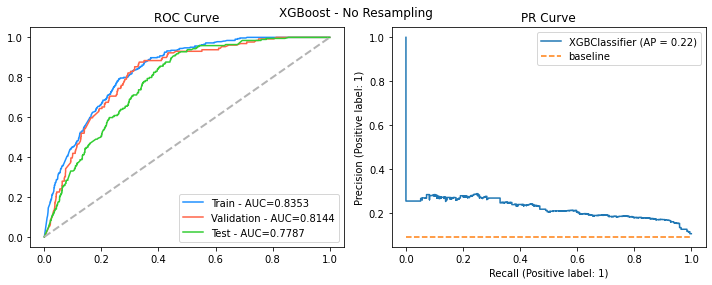

In [278]:
params = {'n_estimators': 1483, 'max_depth': 2, 'reg_alpha': 28, 'reg_lambda': 28, 'min_child_weight': 2, 'gamma': 4, 'learning_rate': 0.10402708455639181, 'colsample_bytree': 0.75}
plot_xgb_roc_curve(params, 'XGBoost - No Resampling')

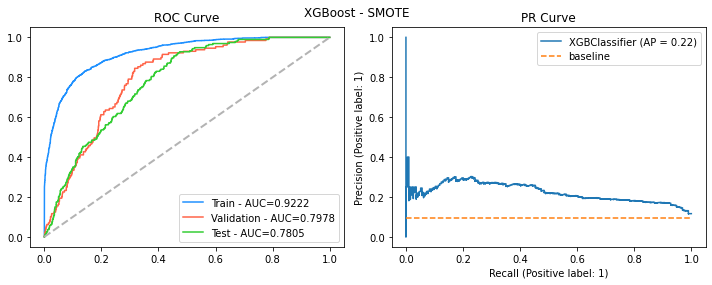

In [279]:
params = {'n_estimators': 965, 'max_depth': 17, 'reg_alpha': 27, 'reg_lambda': 28, 'min_child_weight': 8, 'gamma': 10, 'learning_rate': 0.07545838831803692, 'colsample_bytree': 0.32}
plot_xgb_roc_curve(params, 'XGBoost - SMOTE', resampler=smote)

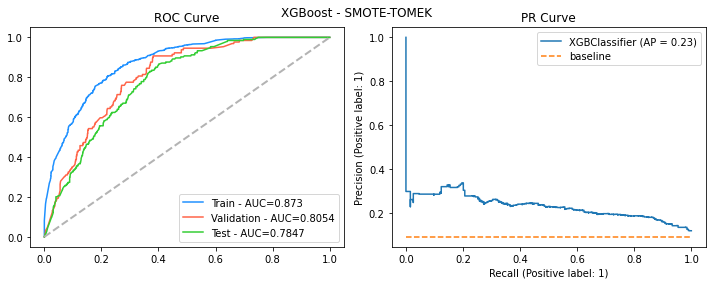

In [280]:
params = {'n_estimators': 500, 'max_depth': 2, 'reg_alpha': 21, 'reg_lambda': 0, 'min_child_weight': 2, 'gamma': 10, 'learning_rate': 0.020908568263150698, 'colsample_bytree': 1.0}
plot_xgb_roc_curve(params, 'XGBoost - SMOTE-TOMEK', resampler=smote_tomek)

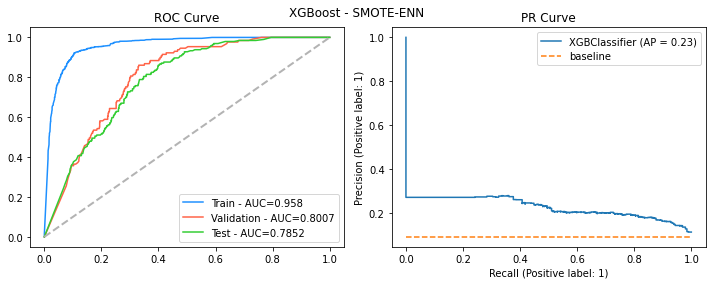

In [281]:
params = {'n_estimators': 1258, 'max_depth': 23, 'reg_alpha': 0, 'reg_lambda': 11, 'min_child_weight': 10, 'gamma': 10, 'learning_rate': 0.1984173751687537, 'colsample_bytree': 0.98}
plot_xgb_roc_curve(params, 'XGBoost - SMOTE-ENN', resampler=smote_enn)

# Save Model

In [300]:
params = {'n_estimators': 500, 'max_depth': 2, 'reg_alpha': 21, 'reg_lambda': 0, 'min_child_weight': 2, 'gamma': 10, 'learning_rate': 0.020908568263150698, 'colsample_bytree': 1.0}

X_train_rs, y_train_rs = get_resample(X, y, resampler=smote_tomek)

scale_pos_weight = (len(y_train_rs) - sum(y_train_rs)) / sum(y_train_rs)

model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=random_state, **params)
model = model.fit(X_train_rs, y_train_rs, eval_metric='auc', verbose=False)

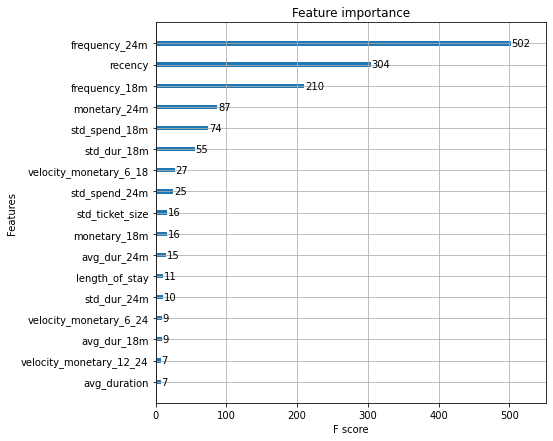

In [11]:
plt.figure(figsize=(7,7))
plot_importance(model, ax=plt.gca());

In [301]:
import joblib
#save model
joblib.dump(model, 'final_model.pkl') 

['final_model.pkl']

# SHAP Tree Explainer

In [5]:
import joblib
#load saved model
model = joblib.load('final_model.pkl')

In [282]:
!pip install shap

     |████████████████████████████████| 358kB 7.8MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491620 sha256=c5eedfcecbecafa0e801e5c7ca23aba316762b87b8301aa290dae1fb6ed27420
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


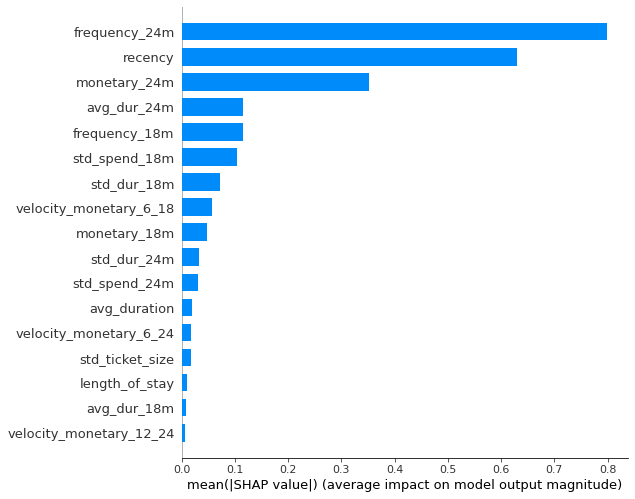

In [303]:
import shap

data = X
shap_values = shap.TreeExplainer(model).shap_values(data)
shap.summary_plot(shap_values, data, plot_type="bar")

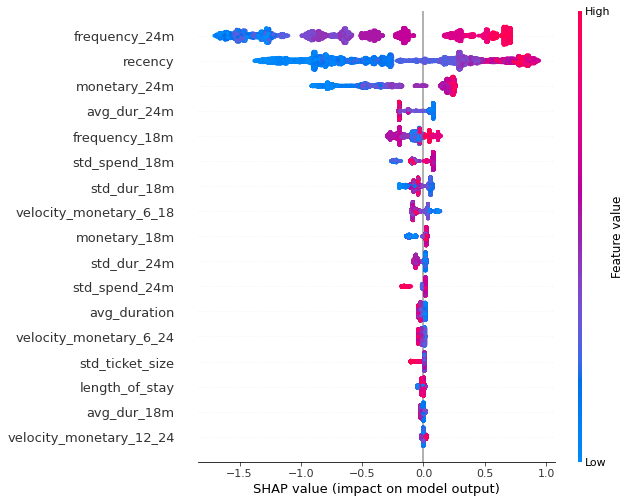

In [304]:
shap.summary_plot(shap_values, data)

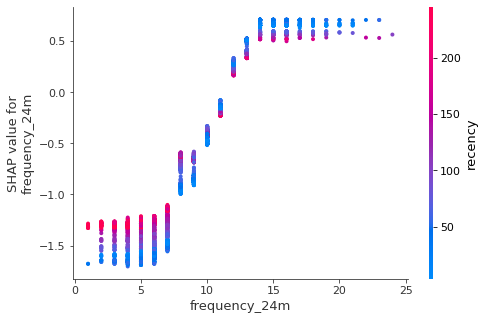

In [305]:
shap.dependence_plot('frequency_24m', shap_values, data)

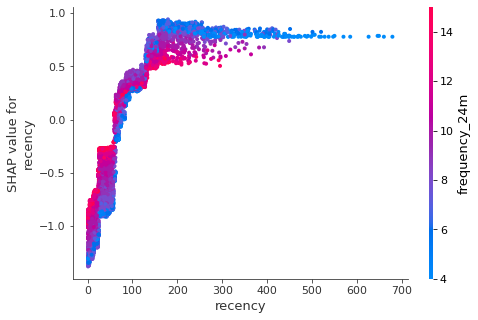

In [306]:
shap.dependence_plot('recency', shap_values, data)

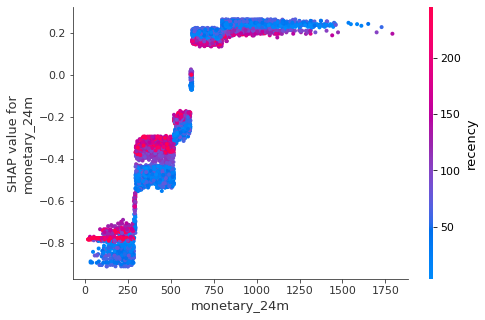

In [307]:
shap.dependence_plot('monetary_24m', shap_values, data)